In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Tau Ceti will make a good proxy for late G stars. E140M data, will need to put it through STISfix.

In [59]:
star = 'tau_ceti'
path = '/media/david/2tb_ext_hd/hddata/meats/hst/{}/'.format(star)
x1ds = np.hstack((glob.glob('{}*x1d.fits'.format(path)), glob.glob('{}*sx1.fits'.format(path))))
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/tau_ceti/o5cy01010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/tau_ceti/o5cy01020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/tau_ceti/oee504010_x1d.fits'],
      dtype='<U68')

/media/david/2tb_ext_hd/hddata/meats/hst/tau_ceti/o5cy01010_x1d.fits
E140M


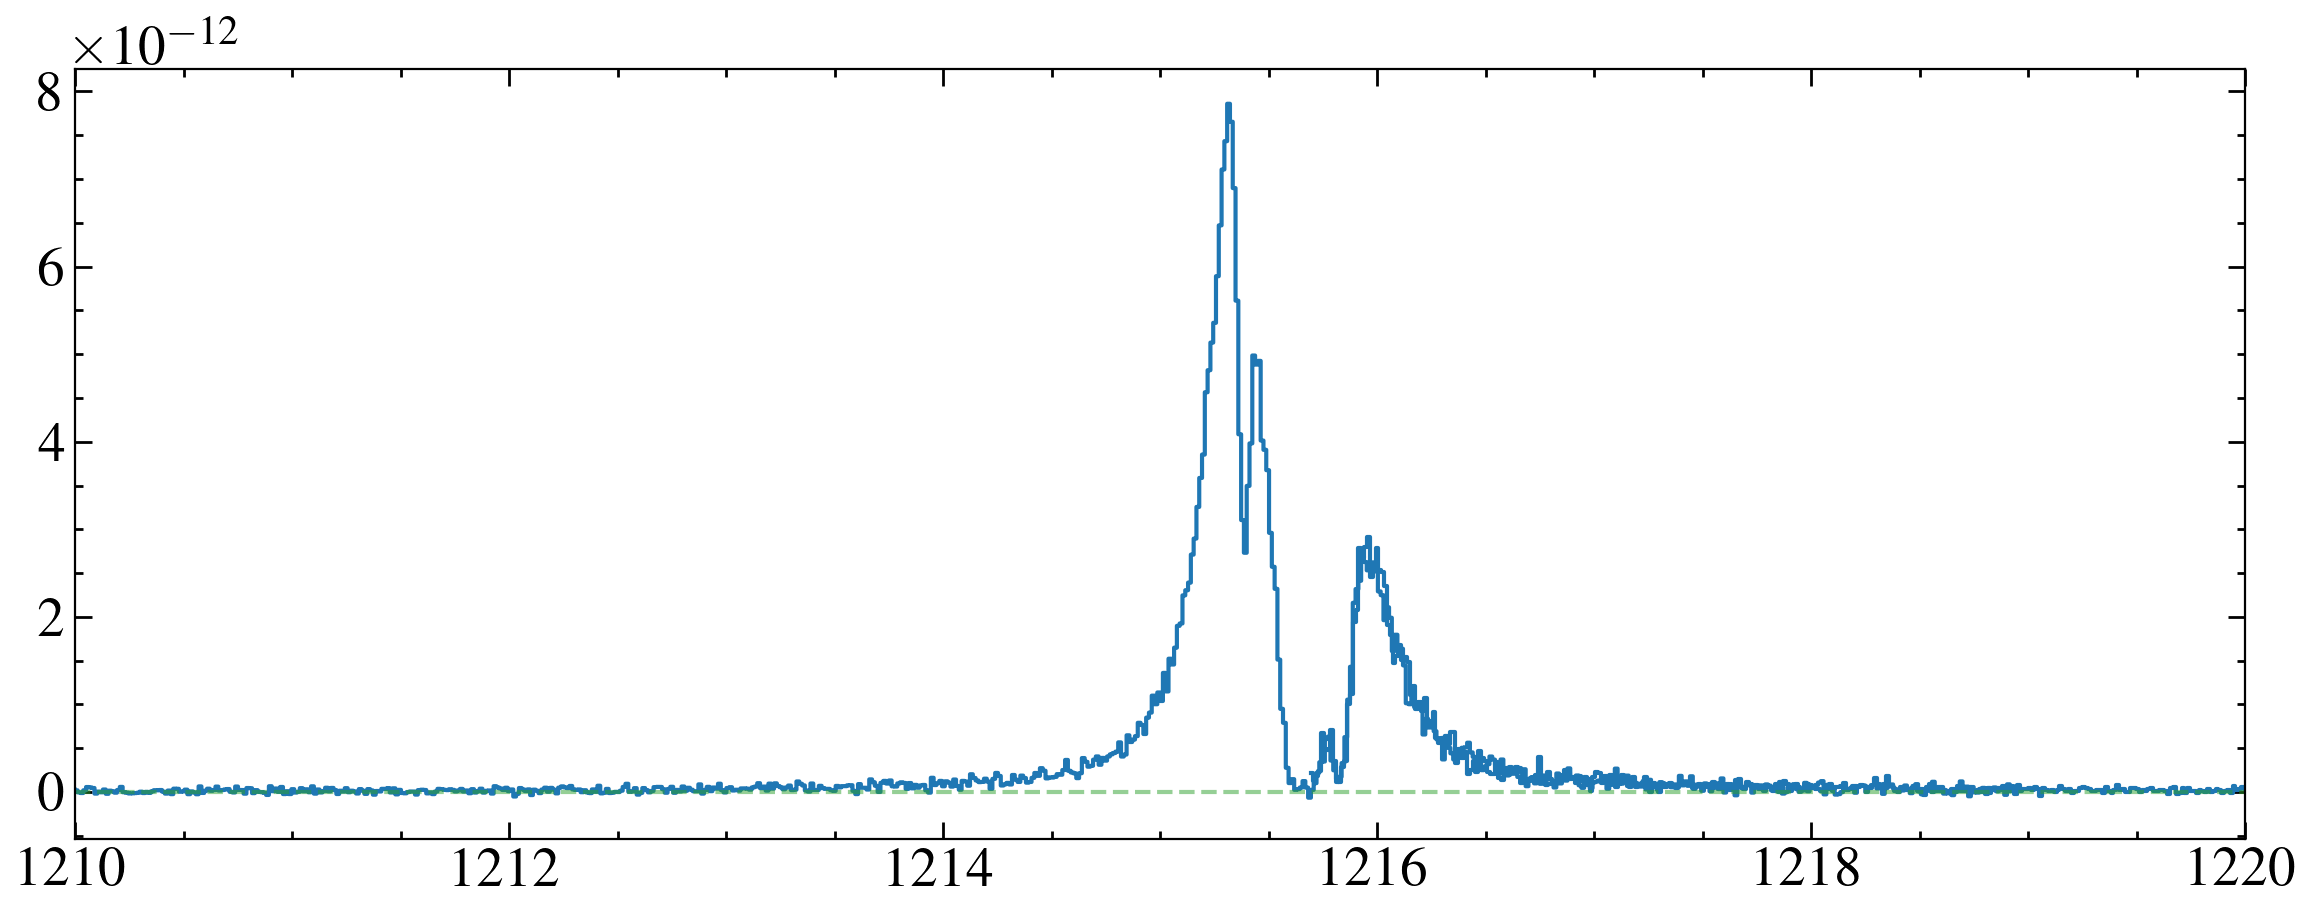

/media/david/2tb_ext_hd/hddata/meats/hst/tau_ceti/o5cy01020_x1d.fits
E140M


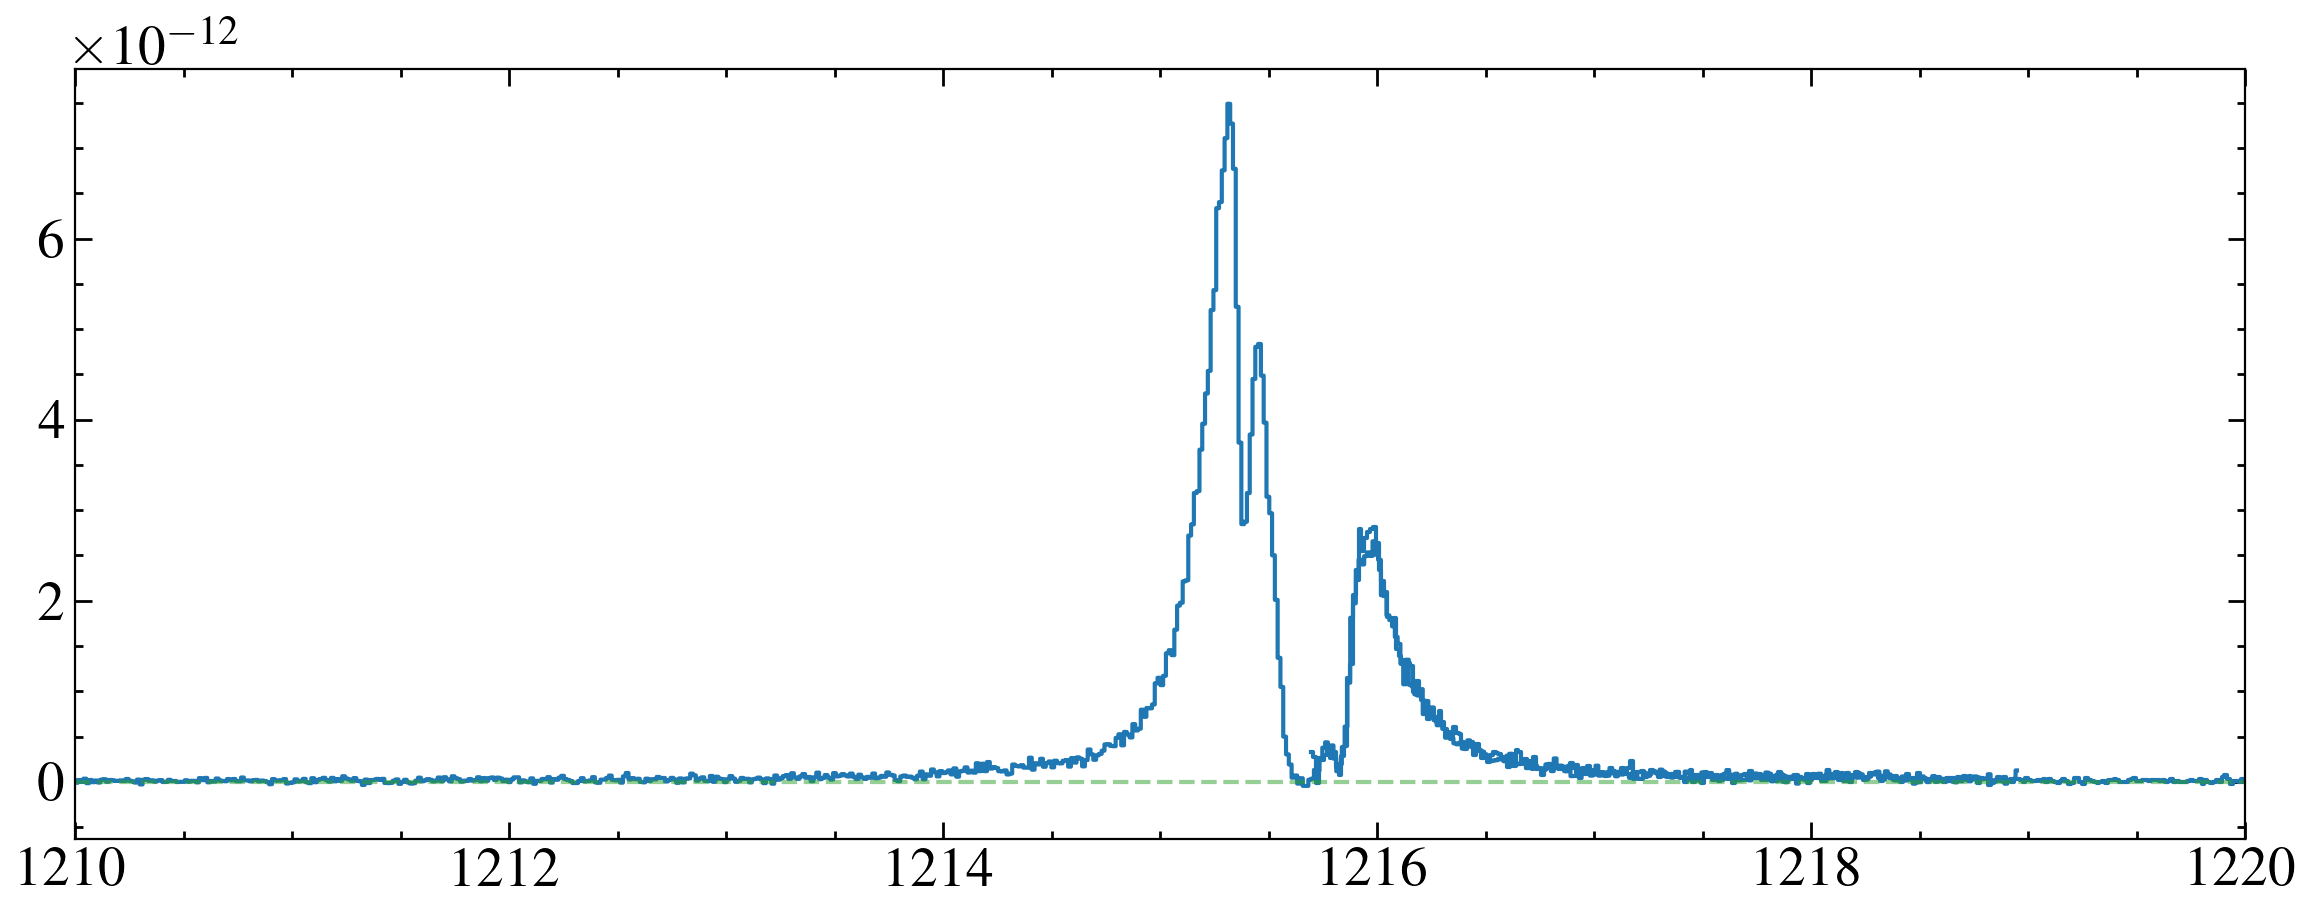

/media/david/2tb_ext_hd/hddata/meats/hst/tau_ceti/oee504010_x1d.fits
E230H


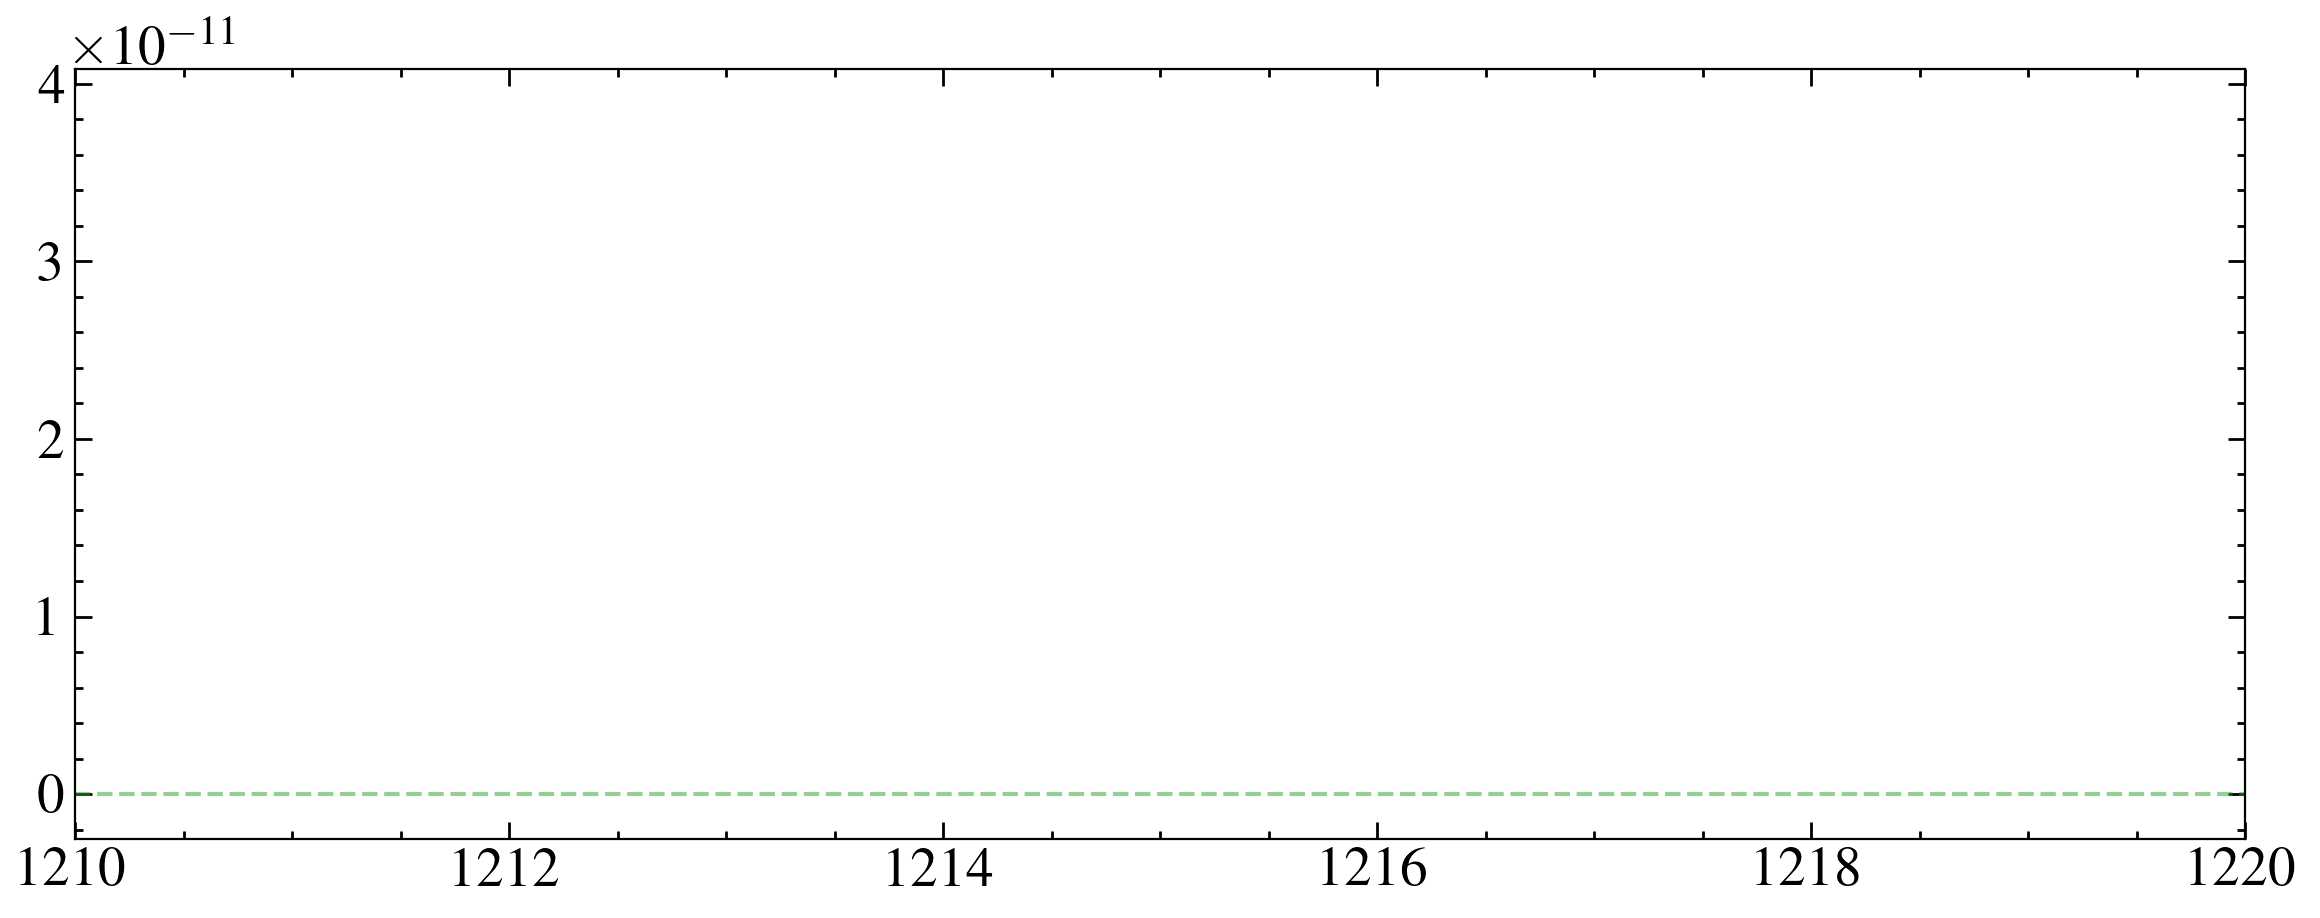

In [60]:
#echelle data
#just found out= apparently not selecting the order sets all of the orders to data?
for x in x1ds:
    print(x)
    print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)
    # print(data['A2Center'])
    for dt in data:
        w, f, e= dt['WAVELENGTH'], dt['FLUX'], dt['ERROR']
        mask = w > 1160
        w, f, e = w[mask], f[mask], e[mask]
        plt.step(w, f, where='mid', c='C0')
        # plt.step(w, e, where='mid', c='C1')
        # plt.yscale('log')
        # plt.xlim(1300, 1350)
    # plt.ylim(-1e-13, 1e-13)
    plt.xlim(1210, 1220)
    plt.axhline(0, c='C2', alpha=0.5, ls='--')    
    plt.show()


(2790.0, 2810.0)

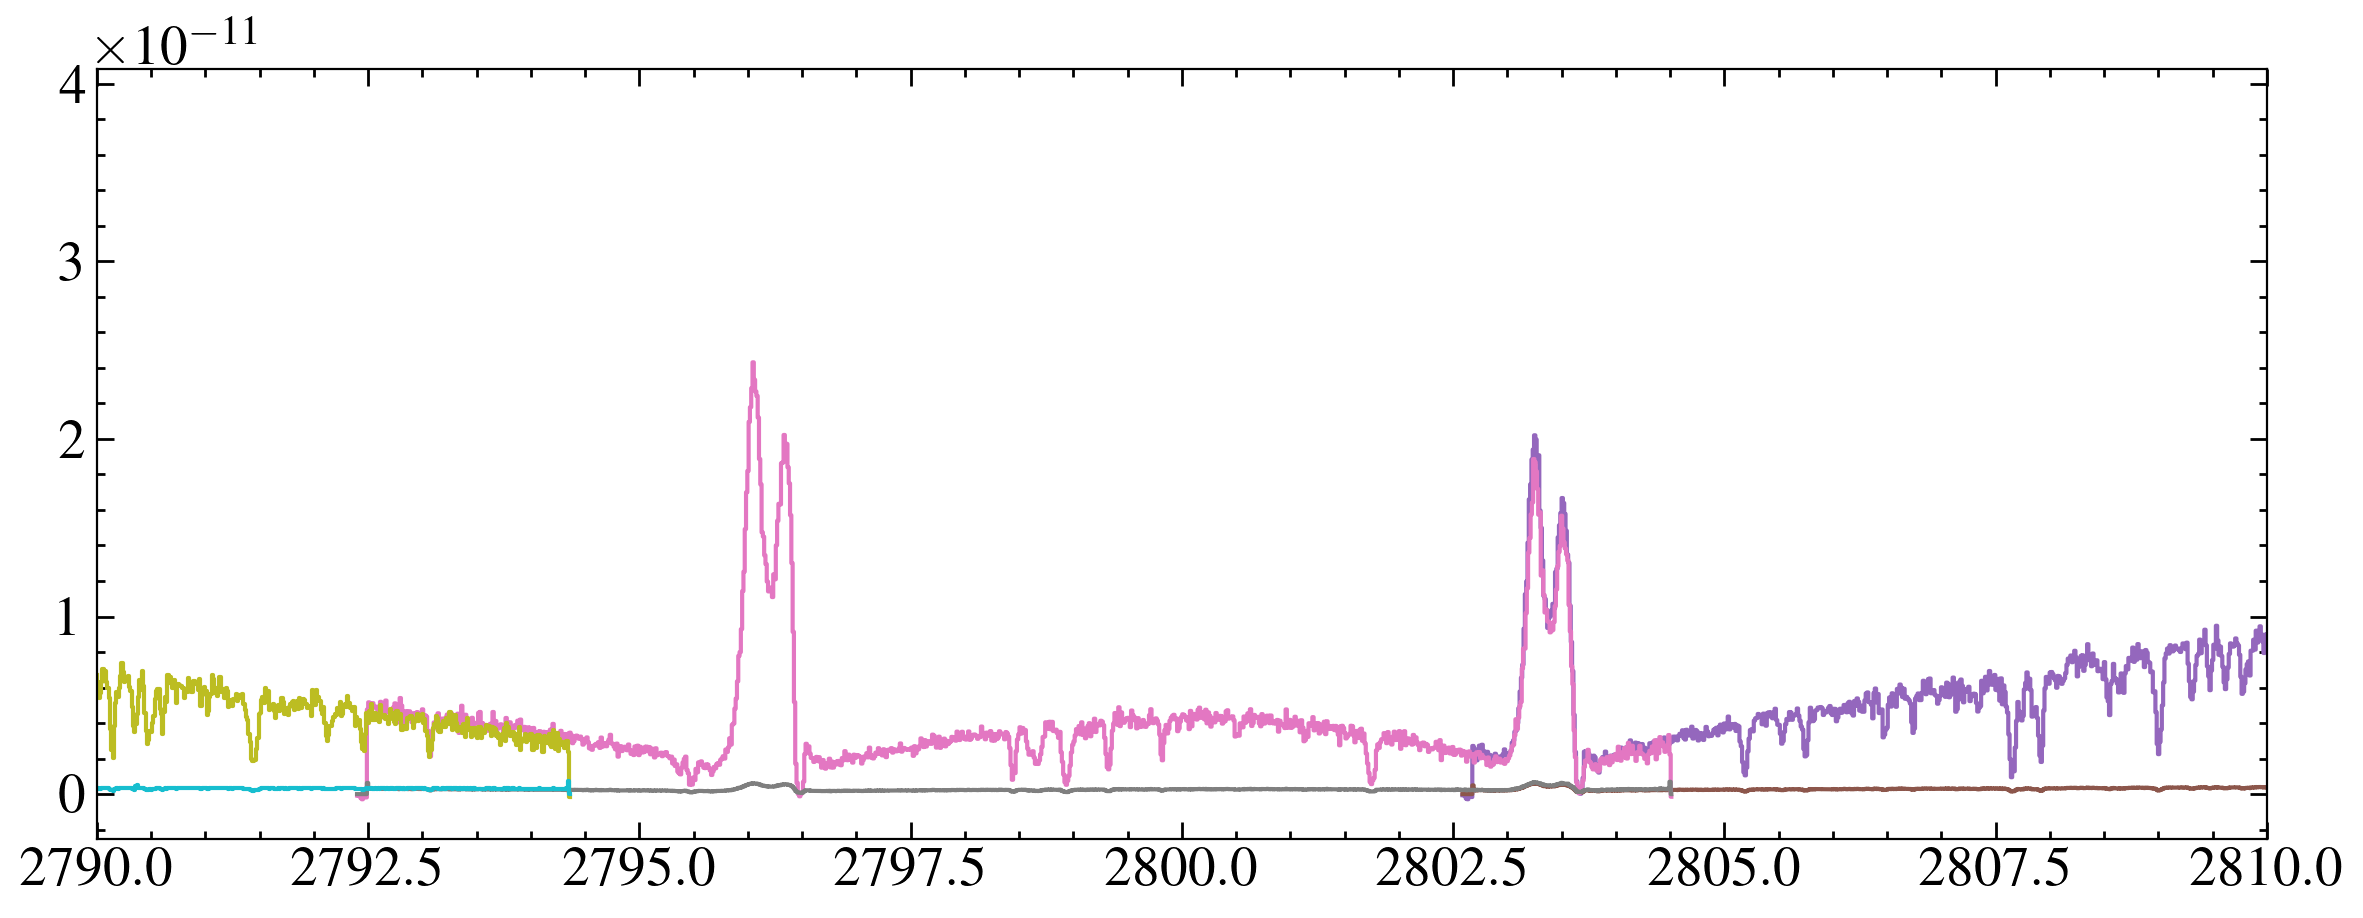

In [4]:
for dt in data:
        w, f, e= dt['WAVELENGTH'], dt['FLUX'], dt['ERROR']
        mask = w > 1160
        w, f, e = w[mask], f[mask], e[mask]
        plt.step(w, f, where='mid')
        plt.step(w, e, where='mid')
plt.xlim(2790, 2810)

In [5]:
import importlib
import stis_echelle_splice as stisfix
importlib.reload(stisfix)


<module 'stis_echelle_splice' from '/home/david/work/meats/SEDs/stis_echelle_splice.py'>

need to modify echelle splice for more than one data array -done I think

In [6]:
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/tau_ceti/o5cy01010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/tau_ceti/o5cy01020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/tau_ceti/oee504010_x1d.fits'],
      dtype='<U68')

oee504010


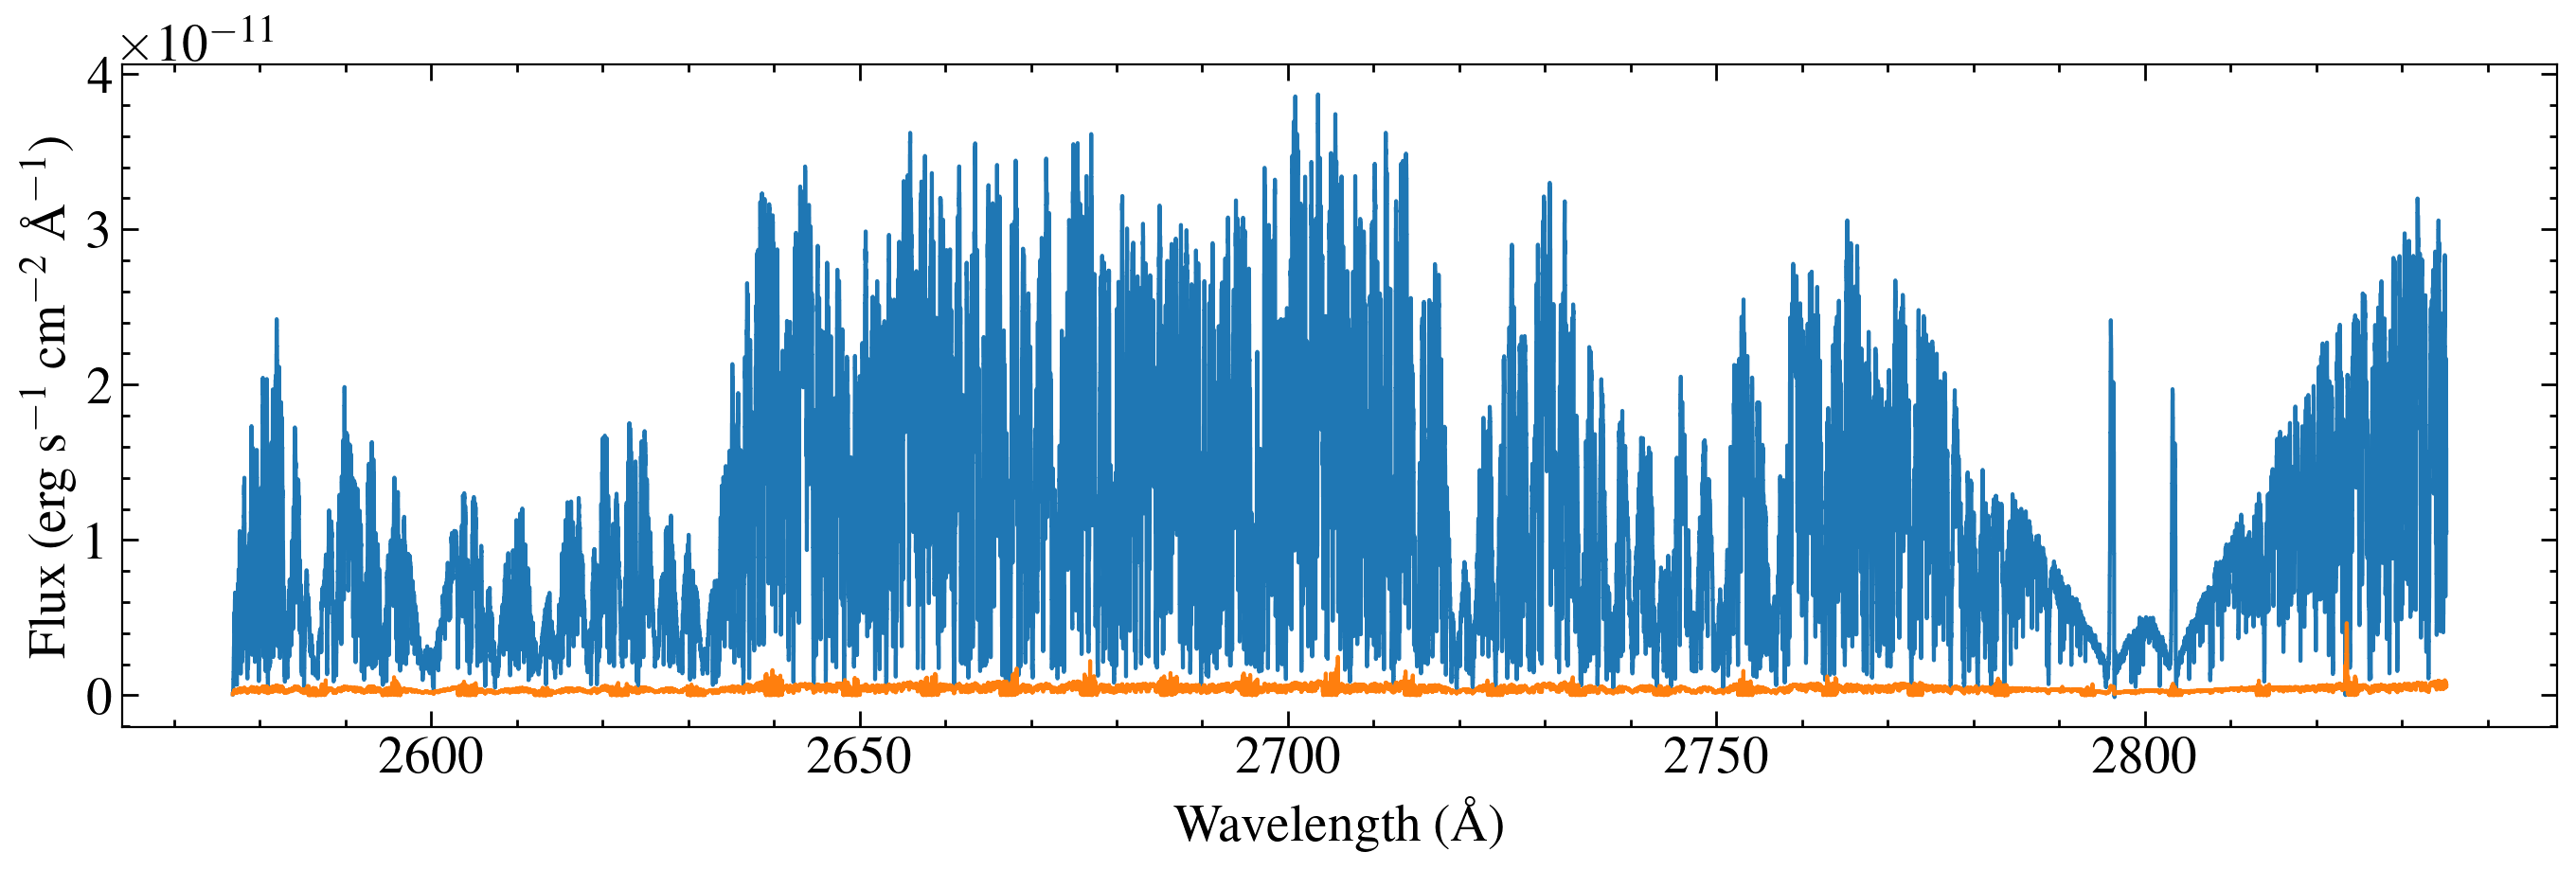

Done


In [7]:
stisfix.splice(filepath = path+'nuv/', outpath = 'misc_data/tau_ceti_spliced/', nclip=17)

misc_data/tau_ceti_spliced/oee504010_spliced.fits
E230H
22493
1


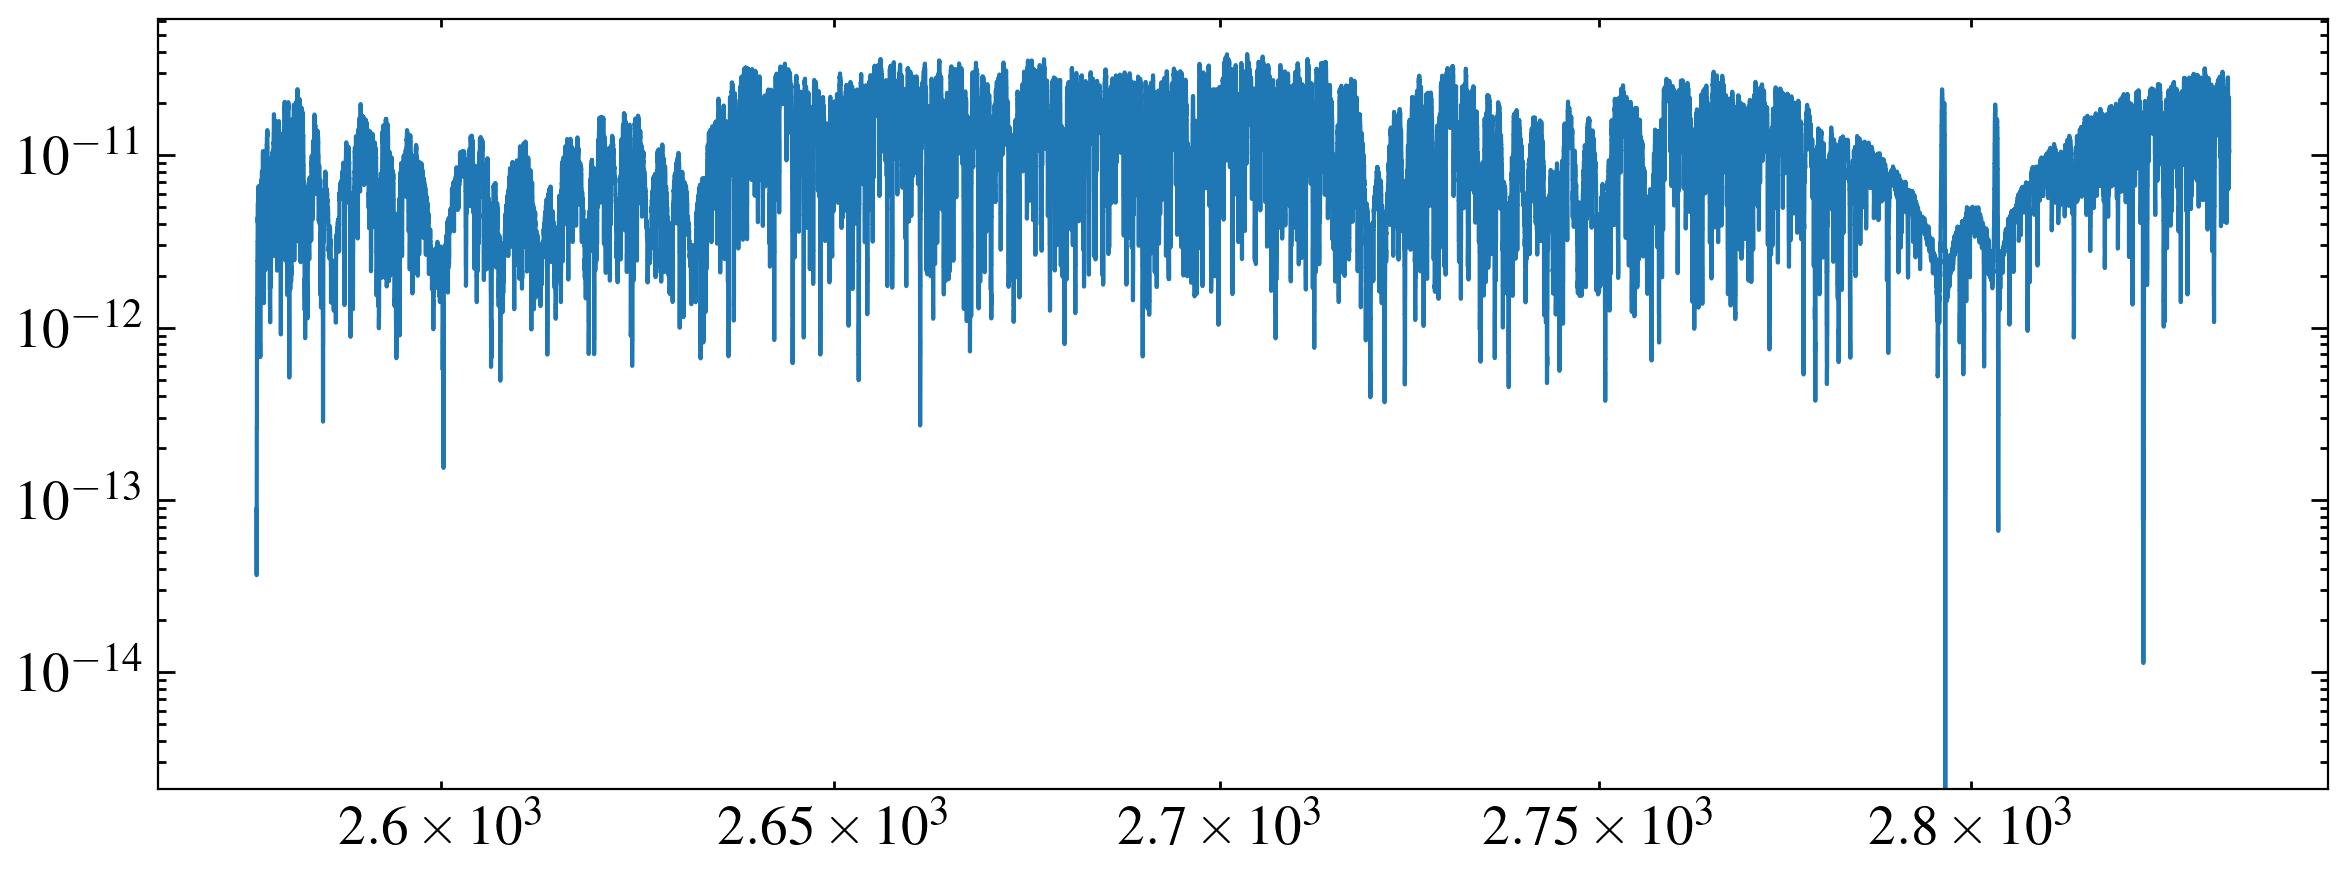

In [8]:
spliced_x1ds = glob.glob('misc_data/tau_ceti_spliced/*spliced.fits')

for x in spliced_x1ds[-1:]:
    print(x)
    print(fits.getheader(x, 0)['OPT_ELEM'])
    data = fits.getdata(x, 1)
    # print(data['A2Center'])
   
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    print(len(f))
    print(len(f[f < 0]))
    mask = (w > 1160) #& (f >0)
    w, f, e = w[mask], f[mask], e[mask]
    plt.step(w, f, where='mid')
    # plt.step(w, e, where='mid', c='C1')
    
plt.yscale('log')
plt.xscale('log')
# plt.xlim(1300, 1350)
# plt.ylim(1e-12)
# plt.show()

In [9]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**2
    return flux,error

In [10]:
demlines = Table.read('DEM_linelist .csv')
demlines.dtype.names

('Ion', 'Wavelength', 'Likelihood to measure', 'Log Formation Temperature')

(1150.0, 1720.0)

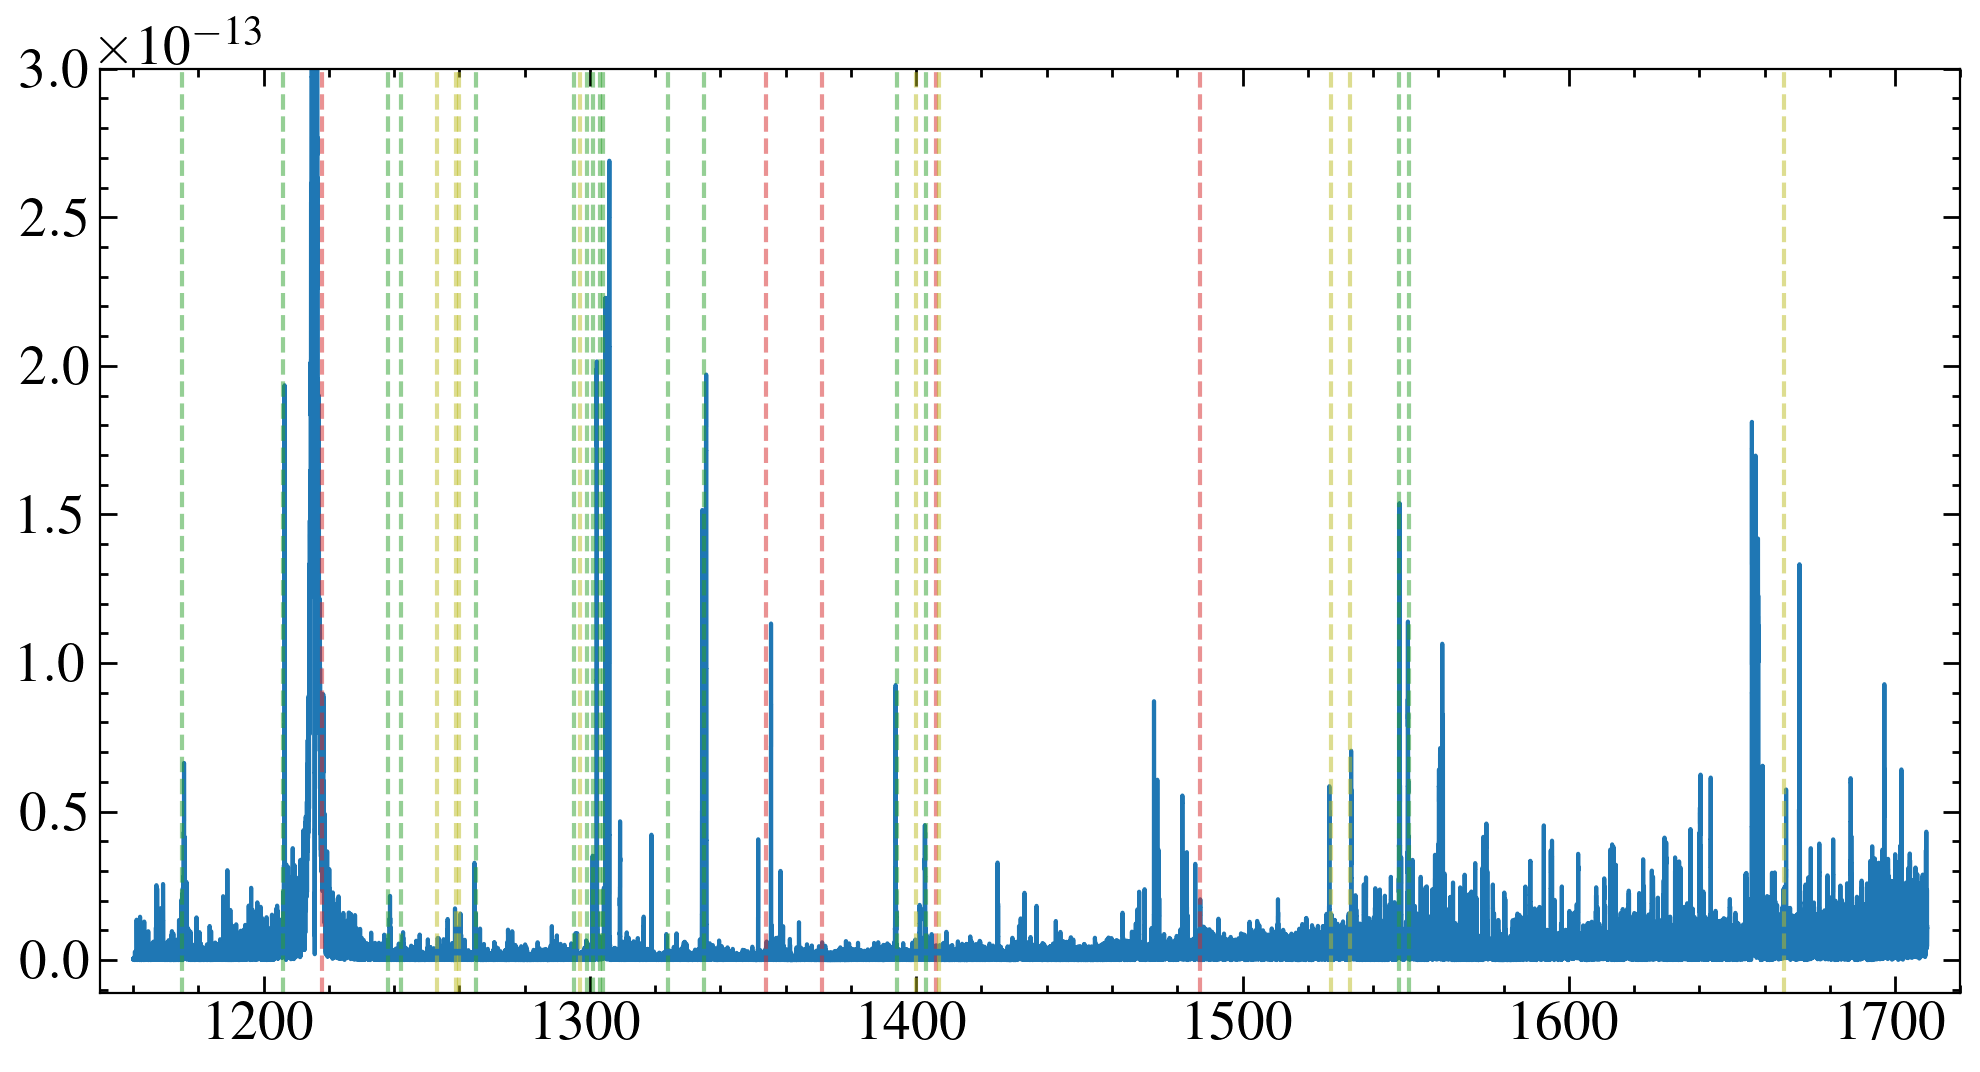

In [11]:
w_fuv = []
f_fuv = []
e_fuv = []
roots = []
n=0
for x in spliced_x1ds:
    data = fits.getdata(x, 1)
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    grating = fits.getheader(x, 0)['OPT_ELEM']
    if grating == 'E140M':
        roots.append(fits.getheader(x, 0)['ROOTNAME'])
        mask = (w > 1160)
        w, f, e = w[mask], f[mask], e[mask]
        if n == 0:
            w_fuv = w
            f_fuv.append(f)
            e_fuv.append(e)
        else:
            f_fuv.append(interp1d(w, f, fill_value='extrapolate')(w_fuv))
            e_fuv.append(interp1d(w, e, fill_value='extrapolate')(w_fuv))            
        n +=1
    if grating == 'E230H':
        mask = (w > 1700) & (w <3130)
        w_nuv, f_nuv, e_nuv = w[mask], f[mask], e[mask]
    if grating == 'G430L':
        mask = (w > 3000) & (w <5520)
        w_opt, f_opt, e_opt = w[mask], f[mask], e[mask]


        
        
f_fuv, e_fuv = spectra_adder(np.array(f_fuv), np.array(e_fuv), scale_correct=True)
mask = (f_fuv > 0)
w_fuv, f_fuv, e_fuv = w_fuv[mask], f_fuv[mask], e_fuv[mask]


plt.figure(figsize=(12, 6))

plt.step(w_fuv, f_fuv, where='mid', label='E140M')
plt.ylim(-0.11e-13, 3e-13)

for i, line in enumerate(demlines['Wavelength']):
    c= 'C2'
    if demlines['Likelihood to measure'][i] == 'Medium':
        c = 'C8'
    if demlines['Likelihood to measure'][i] == 'Low':
        c = 'C3'
    plt.axvline(line, c = c, ls='--', alpha=0.5)

plt.xlim(1150, 1720)
# plt.step(w_fuv, e_fuv, where='mid')
# plt.step(w_nuv, f_nuv, where='mid', label='E230H', zorder=-1)
# plt.xscale('log')
# plt.yscale('log')

(1e-17, 1.0300811148126604e-10)

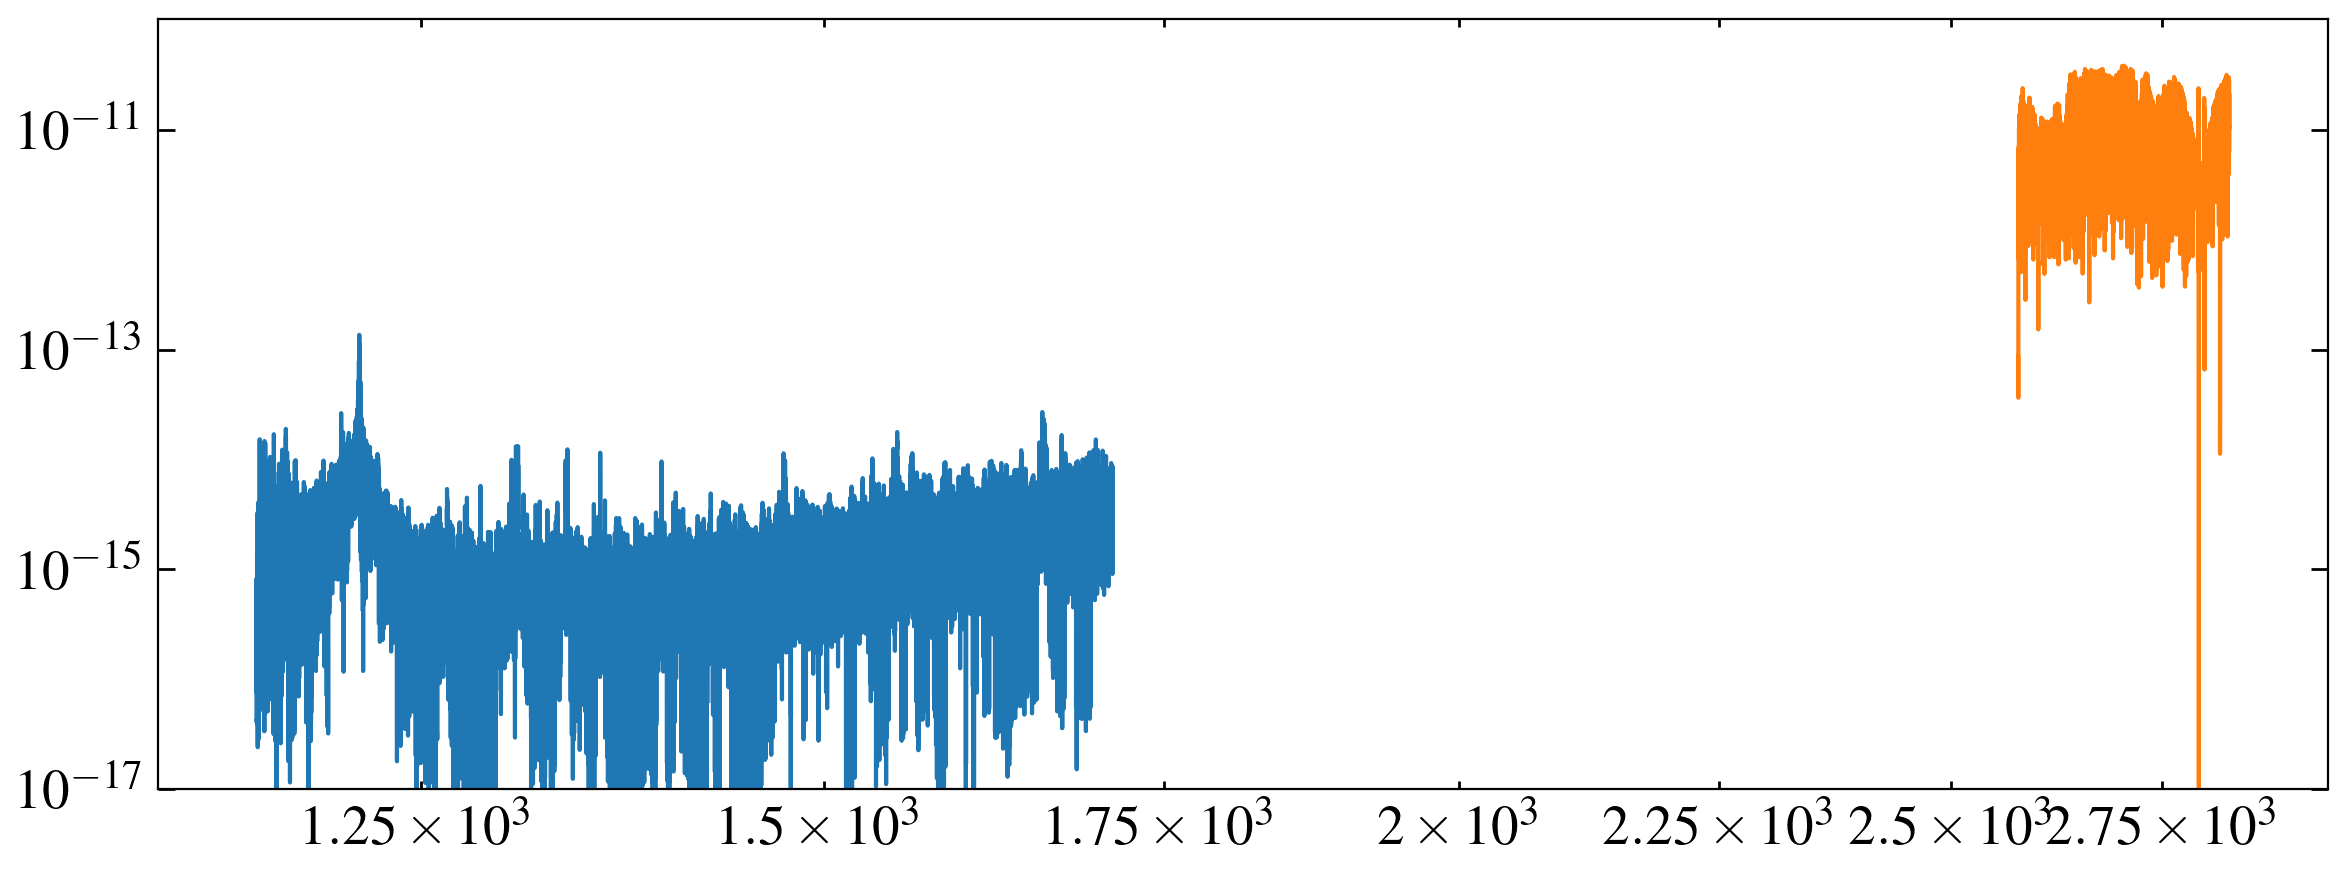

In [12]:
plt.step(w_fuv, e_fuv, where='mid')
plt.step(w_nuv, f_nuv, where='mid', label='E230H', zorder=-1)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-17)

Lya line from BW.

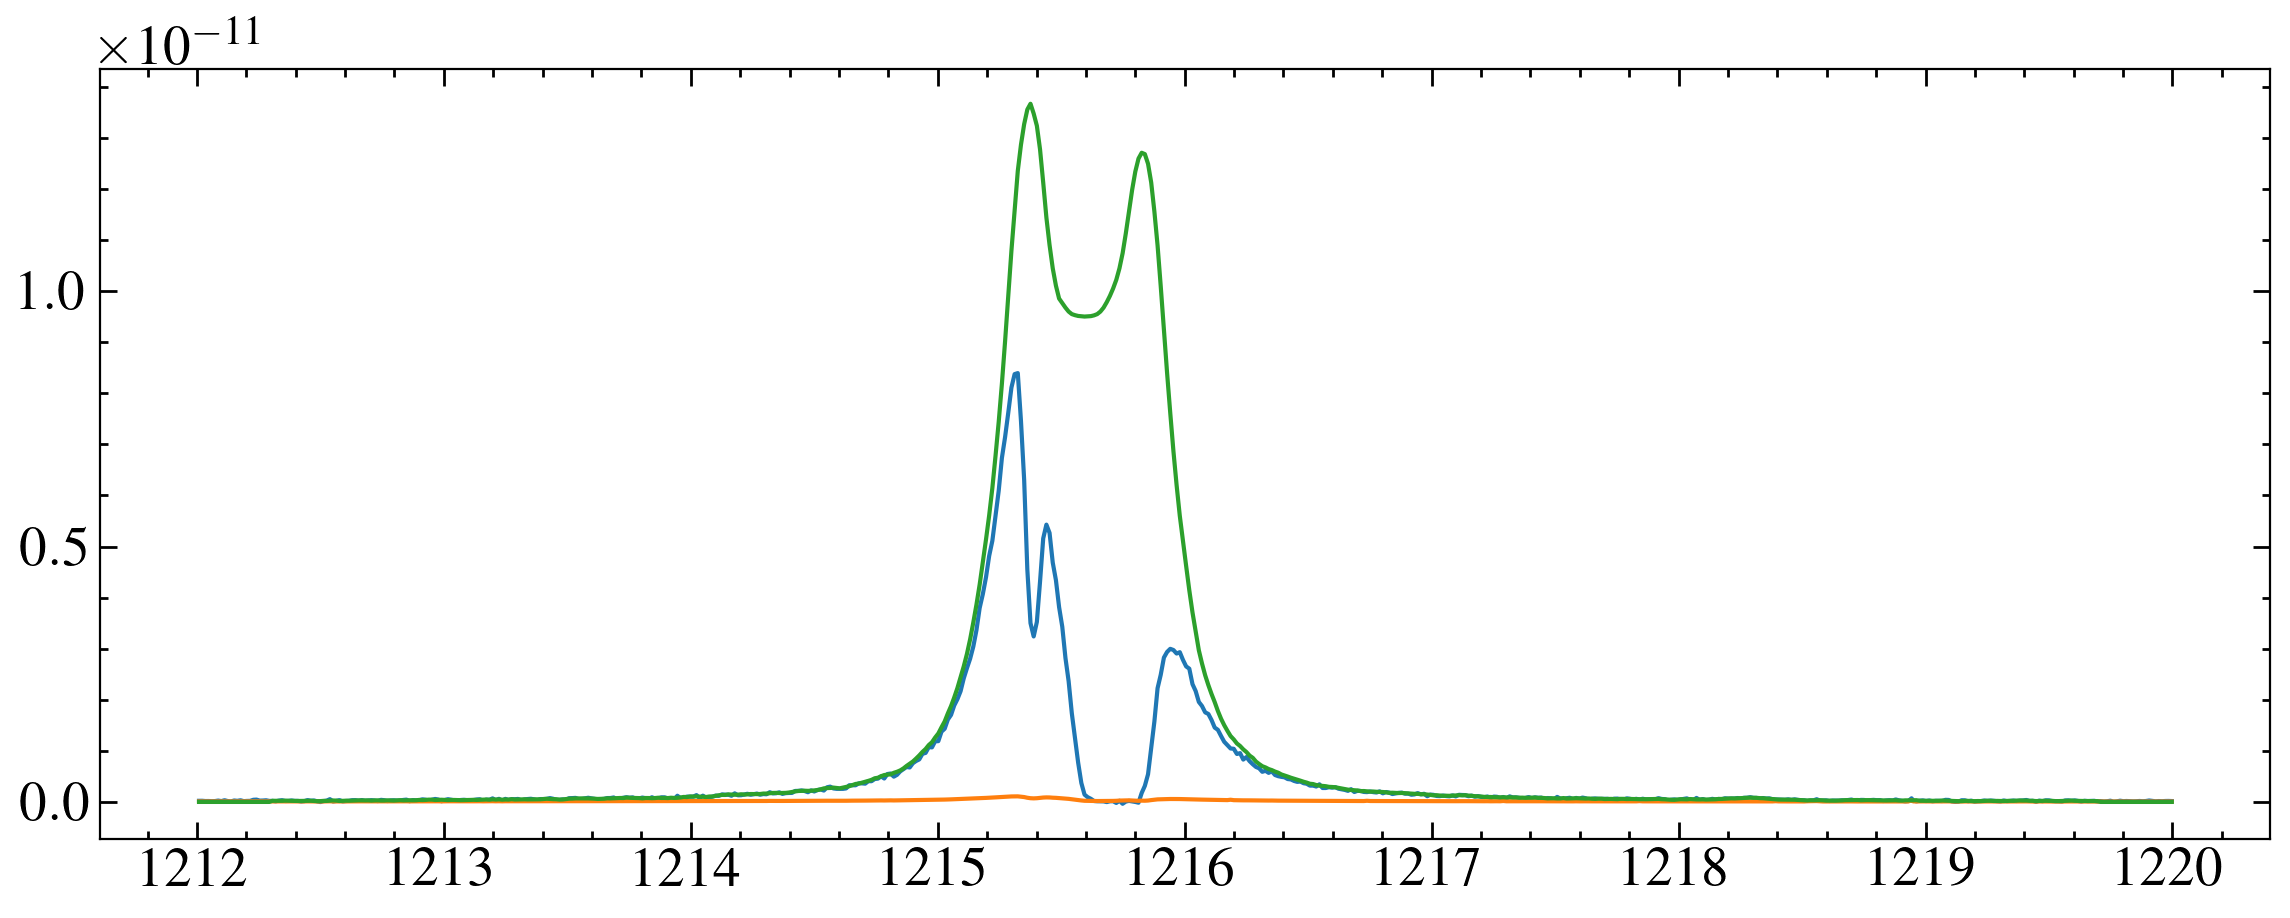

/tmp/ipykernel_136188/4241358633.py:9: RuntimeWarning: divide by zero encountered in divide
  plt.plot(lyaw[lyamask], (lyaf/lyamod)[lyamask])


8.3965612e-12


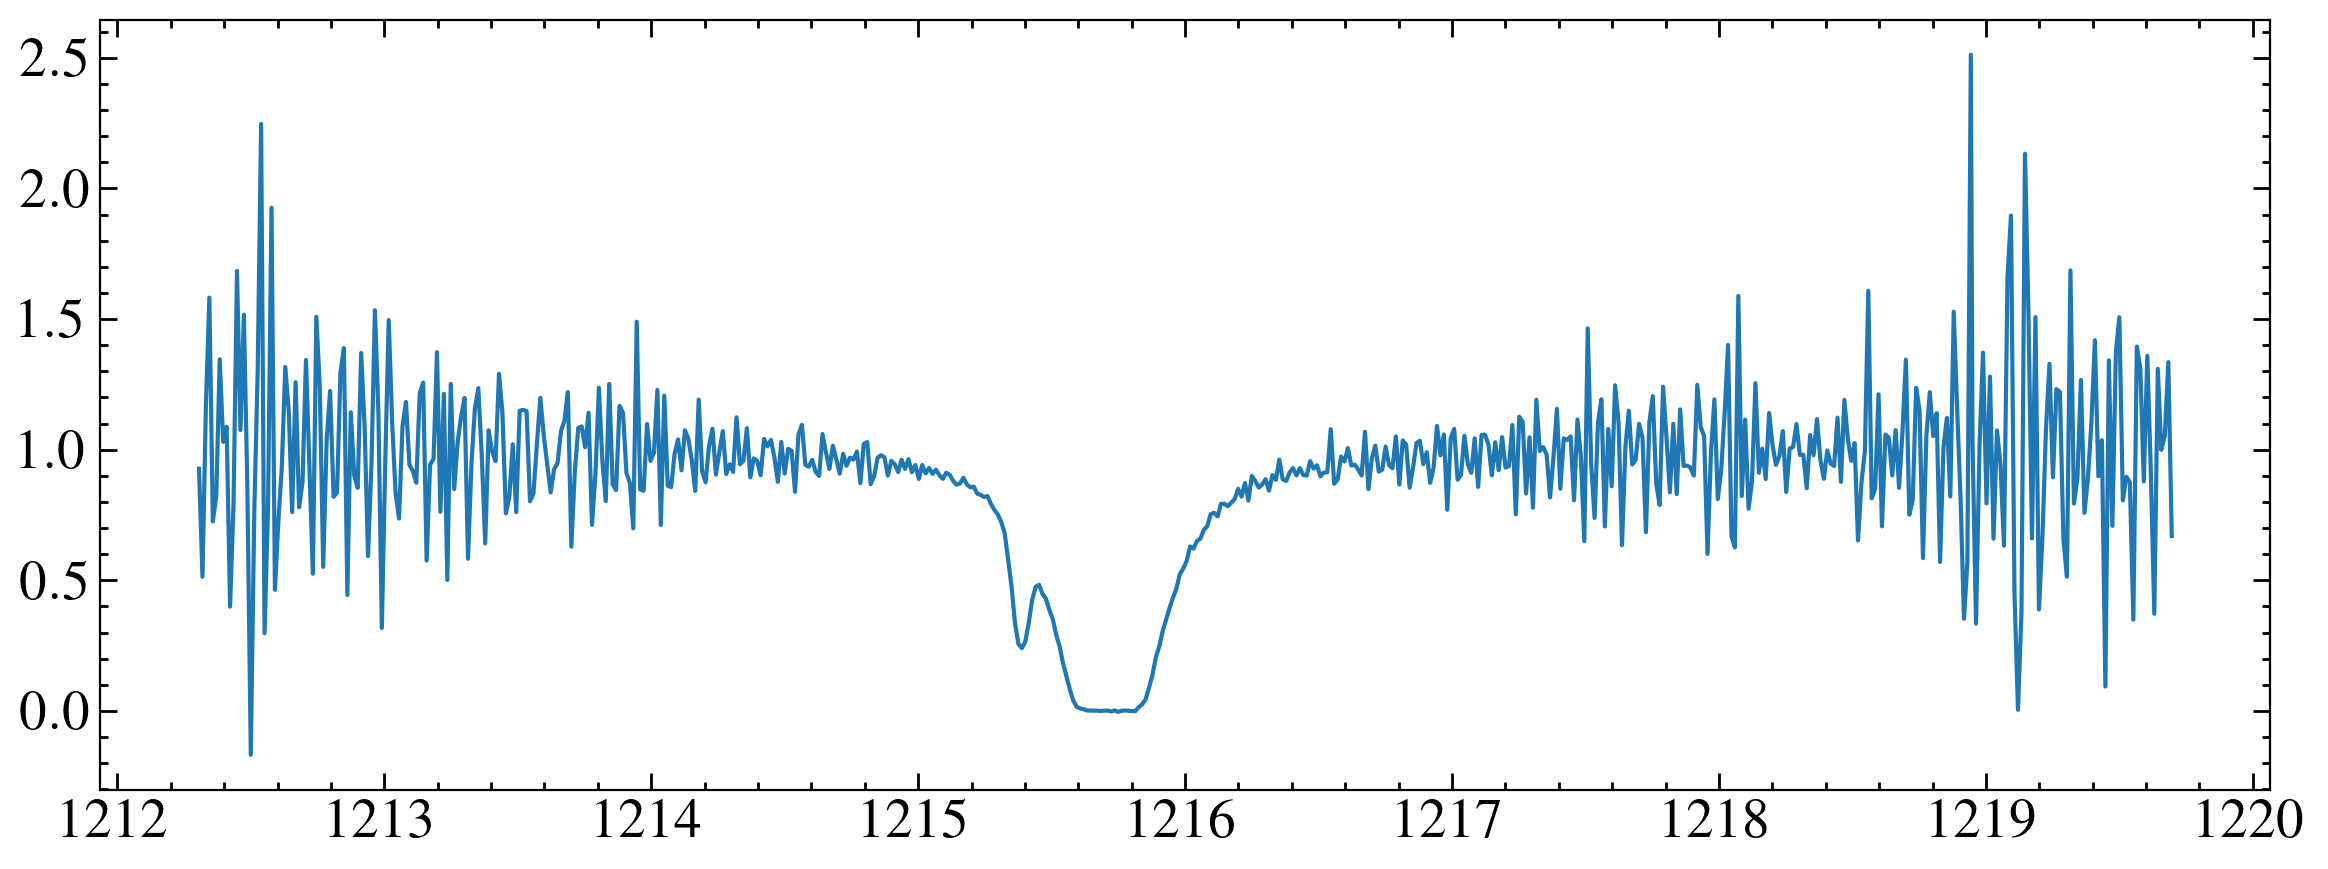

In [13]:
lyapath =  '/media/david/2tb_ext_hd/hddata/meats/lya/taucet_lya.txt'
lyaw, lyaf, lyae, lyamod = np.loadtxt(lyapath, unpack =True)
plt.plot(lyaw, lyaf)
plt.plot(lyaw, lyae)
plt.plot(lyaw, lyamod)

plt.show()
lyamask = (lyamod > 0.0)
plt.plot(lyaw[lyamask], (lyaf/lyamod)[lyamask])
print(np.max(lyaf))

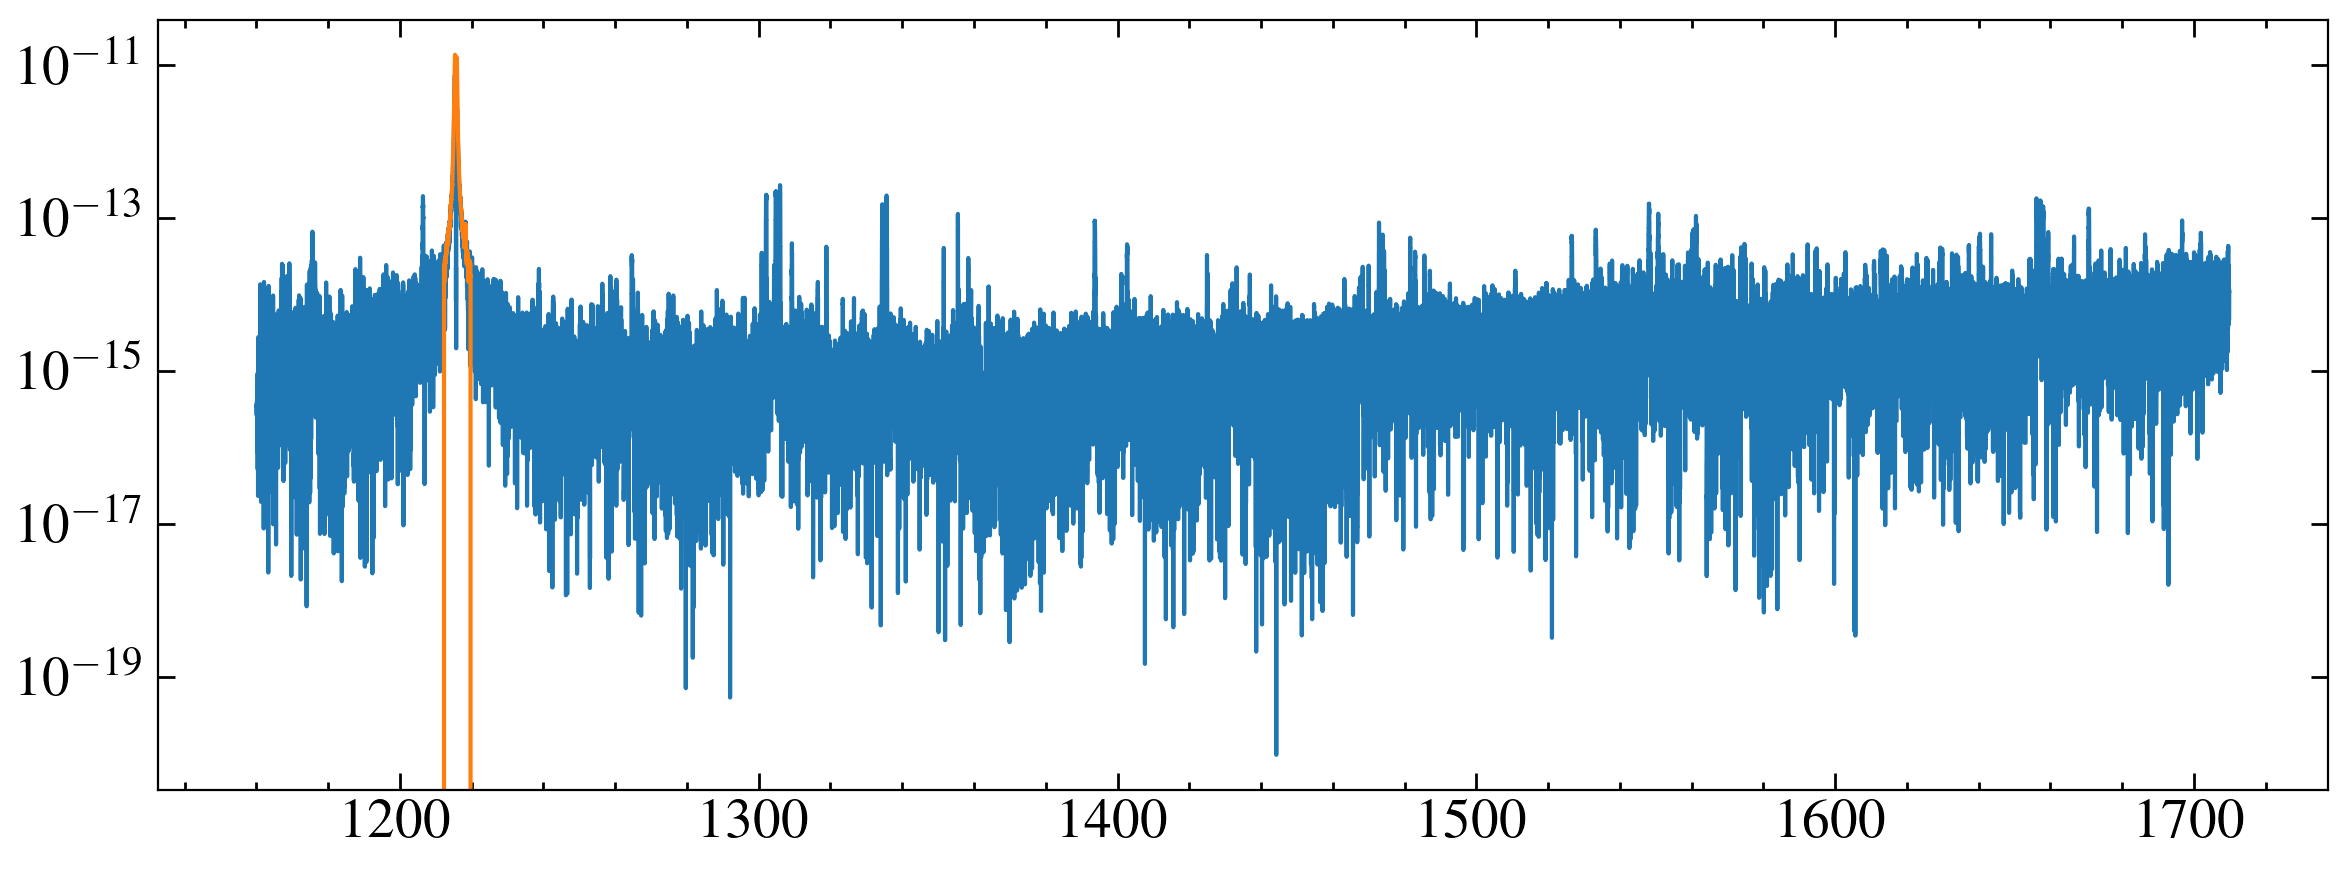

In [14]:
plt.step(w_fuv, f_fuv, where='mid')
plt.plot(lyaw, lyamod)
plt.yscale('log')
# plt.plot(lyaw, lyaf)

# plt.xlim(1210, 1220)

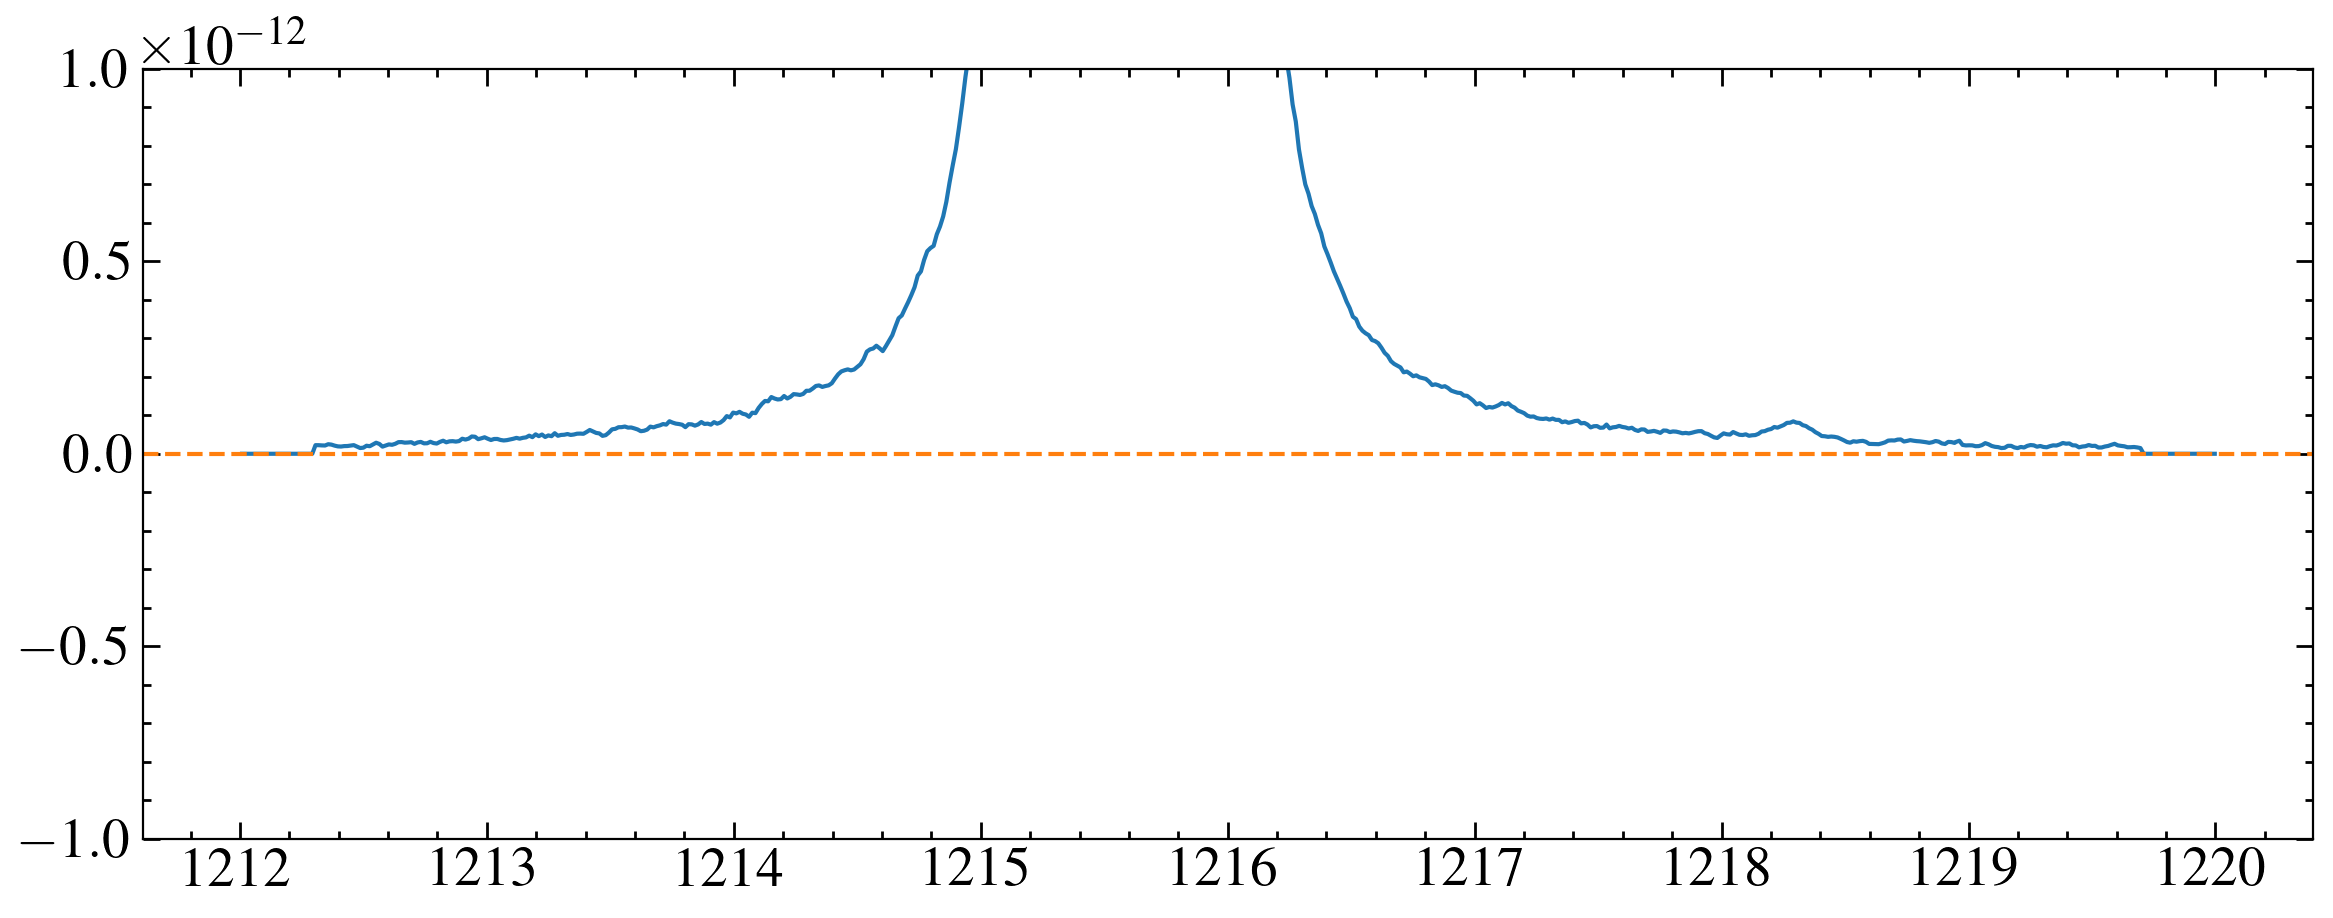

In [15]:
plt.plot(lyaw, lyamod)
plt.ylim(-1e-12, 1e-12)
plt.axhline(0, ls='--', c='C1')

In [16]:
#params from TICv8 via exoplanet archive
import prepare_phoenix_svo as pp
importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.92
teff = 5333
teff_e = np.mean([123.7510, 74.6878])

radius = 0.8330490
distance = 3.60304

save_path = 'models/'
star = 'Tau_Ceti'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
g = 4.56051
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
# pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True, make_error=True)
pdata = Table.read('models/Tau_Ceti_phoenix_interpolated.ecsv')
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

In [17]:
# pmask = (pw > 1700) & (pw < 100000)
# pwi, pfi = pw[pmask], pf[pmask]*normfac
# pwi, pfi = pp.smear(pwi, pfi, 500)
# plt.plot(pwi, pfi)

(1e-17, 7.509244341539583e-10)

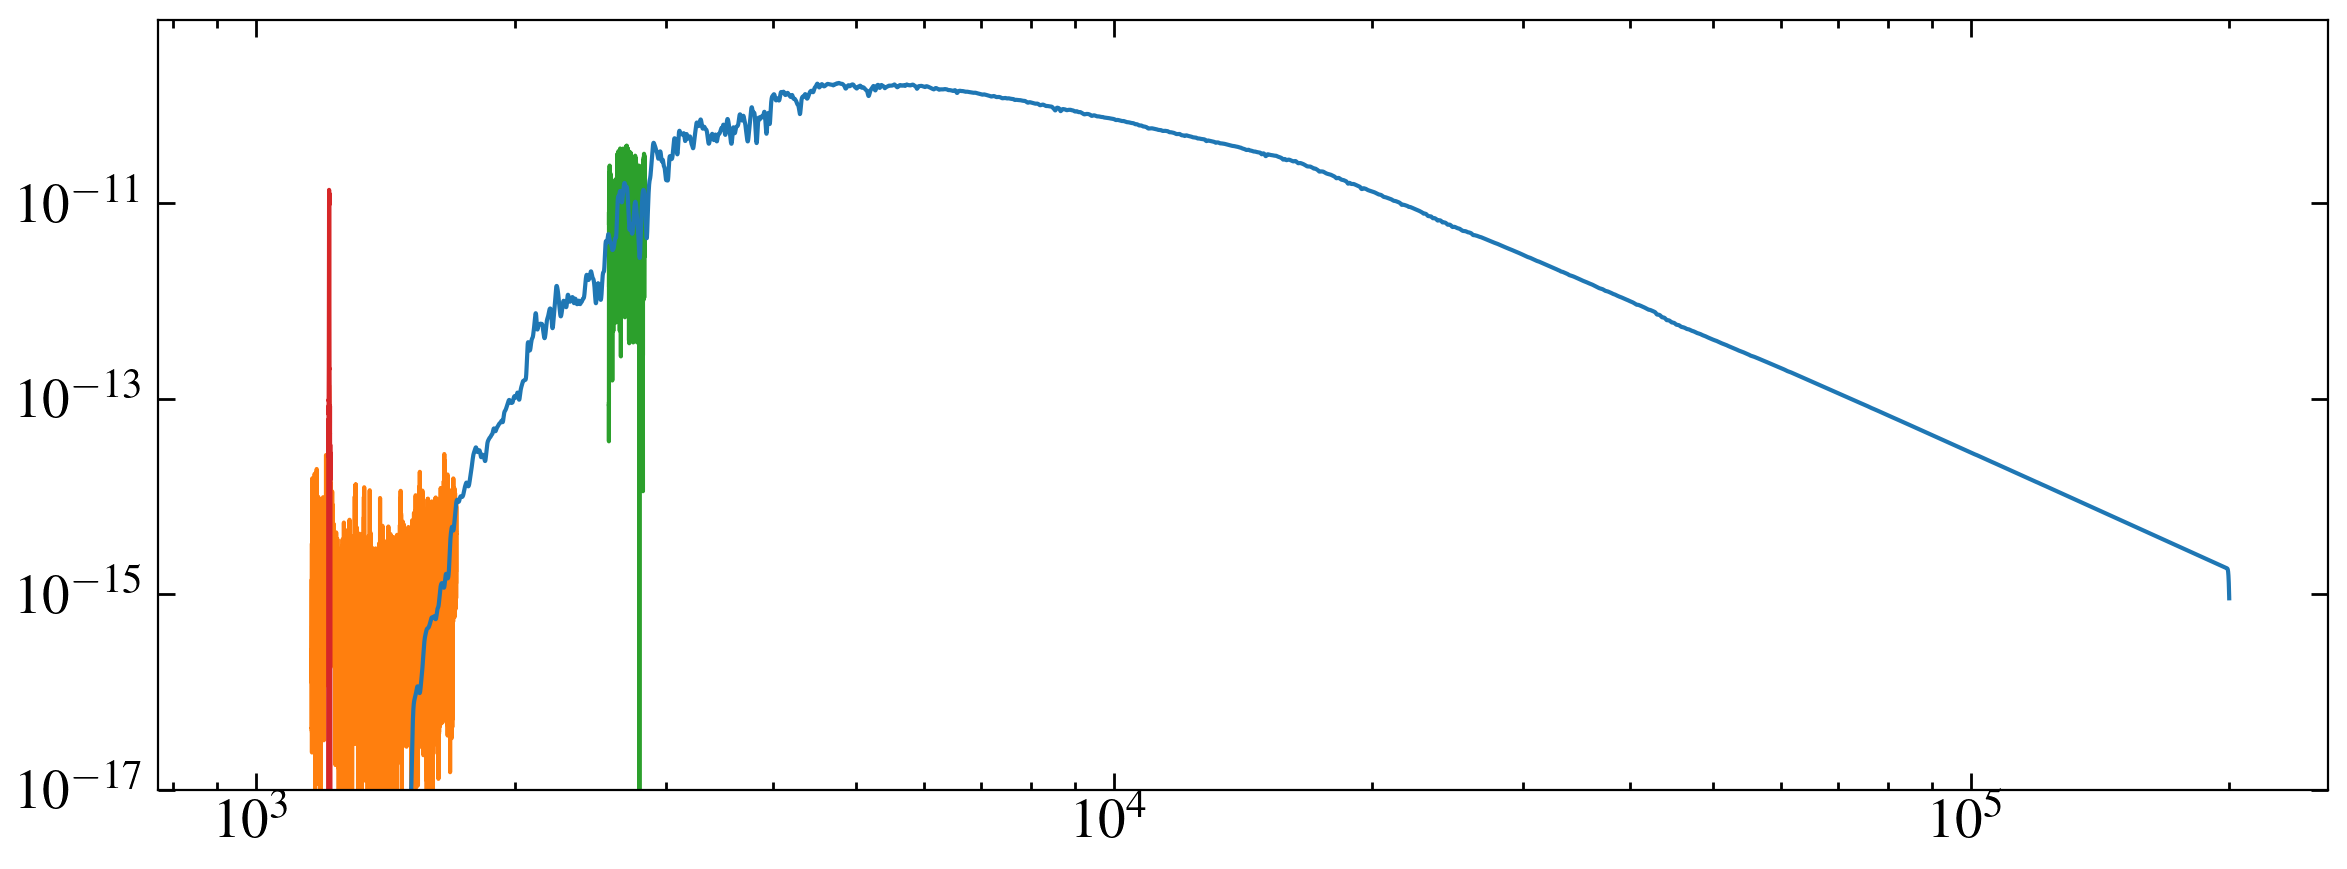

In [18]:
pmask = (pw > 1000) & (pw < 200000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi, 500)

plt.plot(pwi, pfi)

plt.step(w_fuv, e_fuv, where='mid', zorder=-1)
plt.step(w_nuv, f_nuv, where='mid', label='E230H', zorder=-1)
plt.plot(lyaw, lyamod)

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-17)

X-rays? Swift gives some results. XMM better? Also a bunch of IUE data, if I can remember how to open it...need to do some echelle splicing.

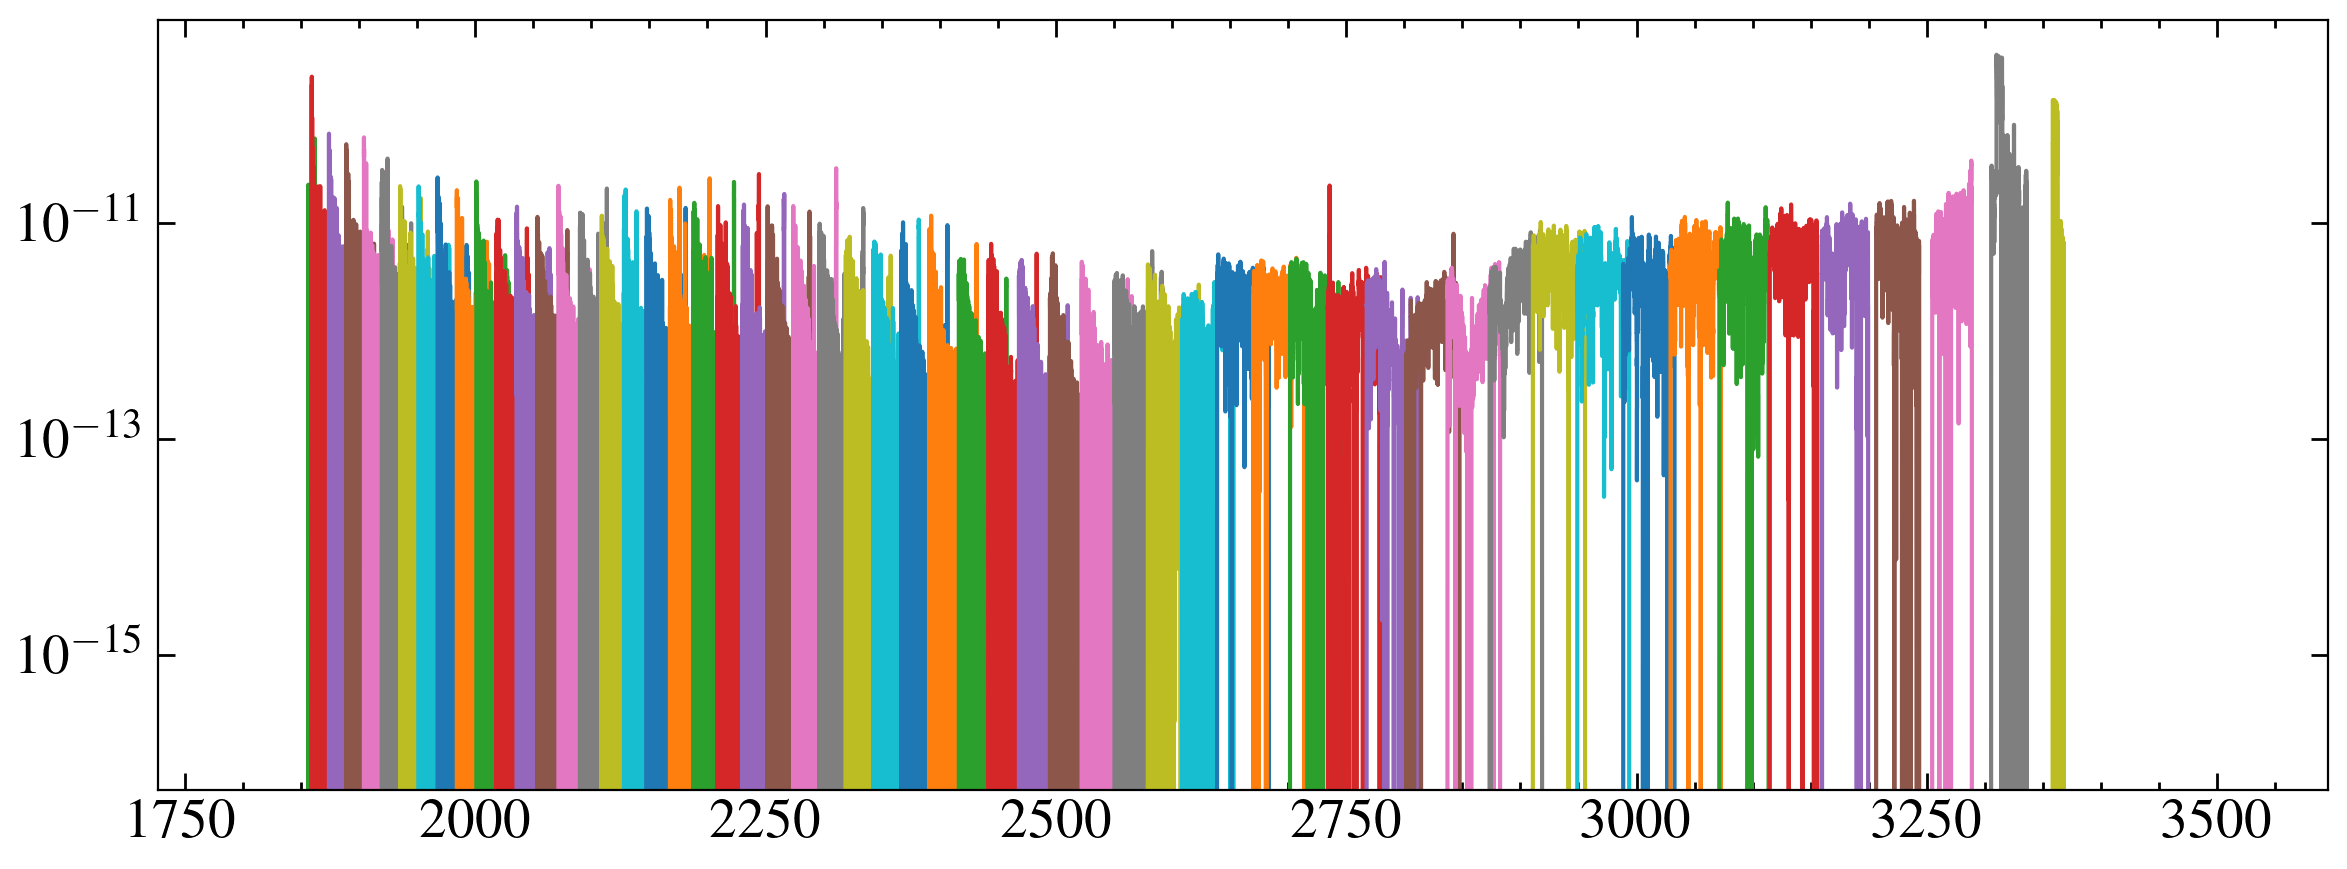

In [19]:
iuepath = '/media/david/2tb_ext_hd/hddata/meats/iue/tau_ceti/'
# swfiles = glob.glob('{}sw*/*.fits'.format(iuepath))

# for sw in swfiles:
#     data = fits.getdata(sw, 1)[0]
#     plt.plot(data['Wave'], data['Flux'])

# useful stuff is in the lw files

testdat = fits.getdata('{}lwr02625/lwr02625.mxhi'.format(iuepath), 1)
for dt in testdat:
    w0 = dt['WAVELENGTH']
    dw = dt['DELTAW']
    flux = dt['ABS_CAL']
    w = np.full(len(flux), w0)
    for i in range(len(flux)):
        w[i] = w[i] +dw*i
    plt.step(w, flux, where='mid')
# plt.step(w_nuv, f_nuv, where='mid', label='E230H', zorder=-1)

plt.yscale('log')

(2780.0, 2830.0)

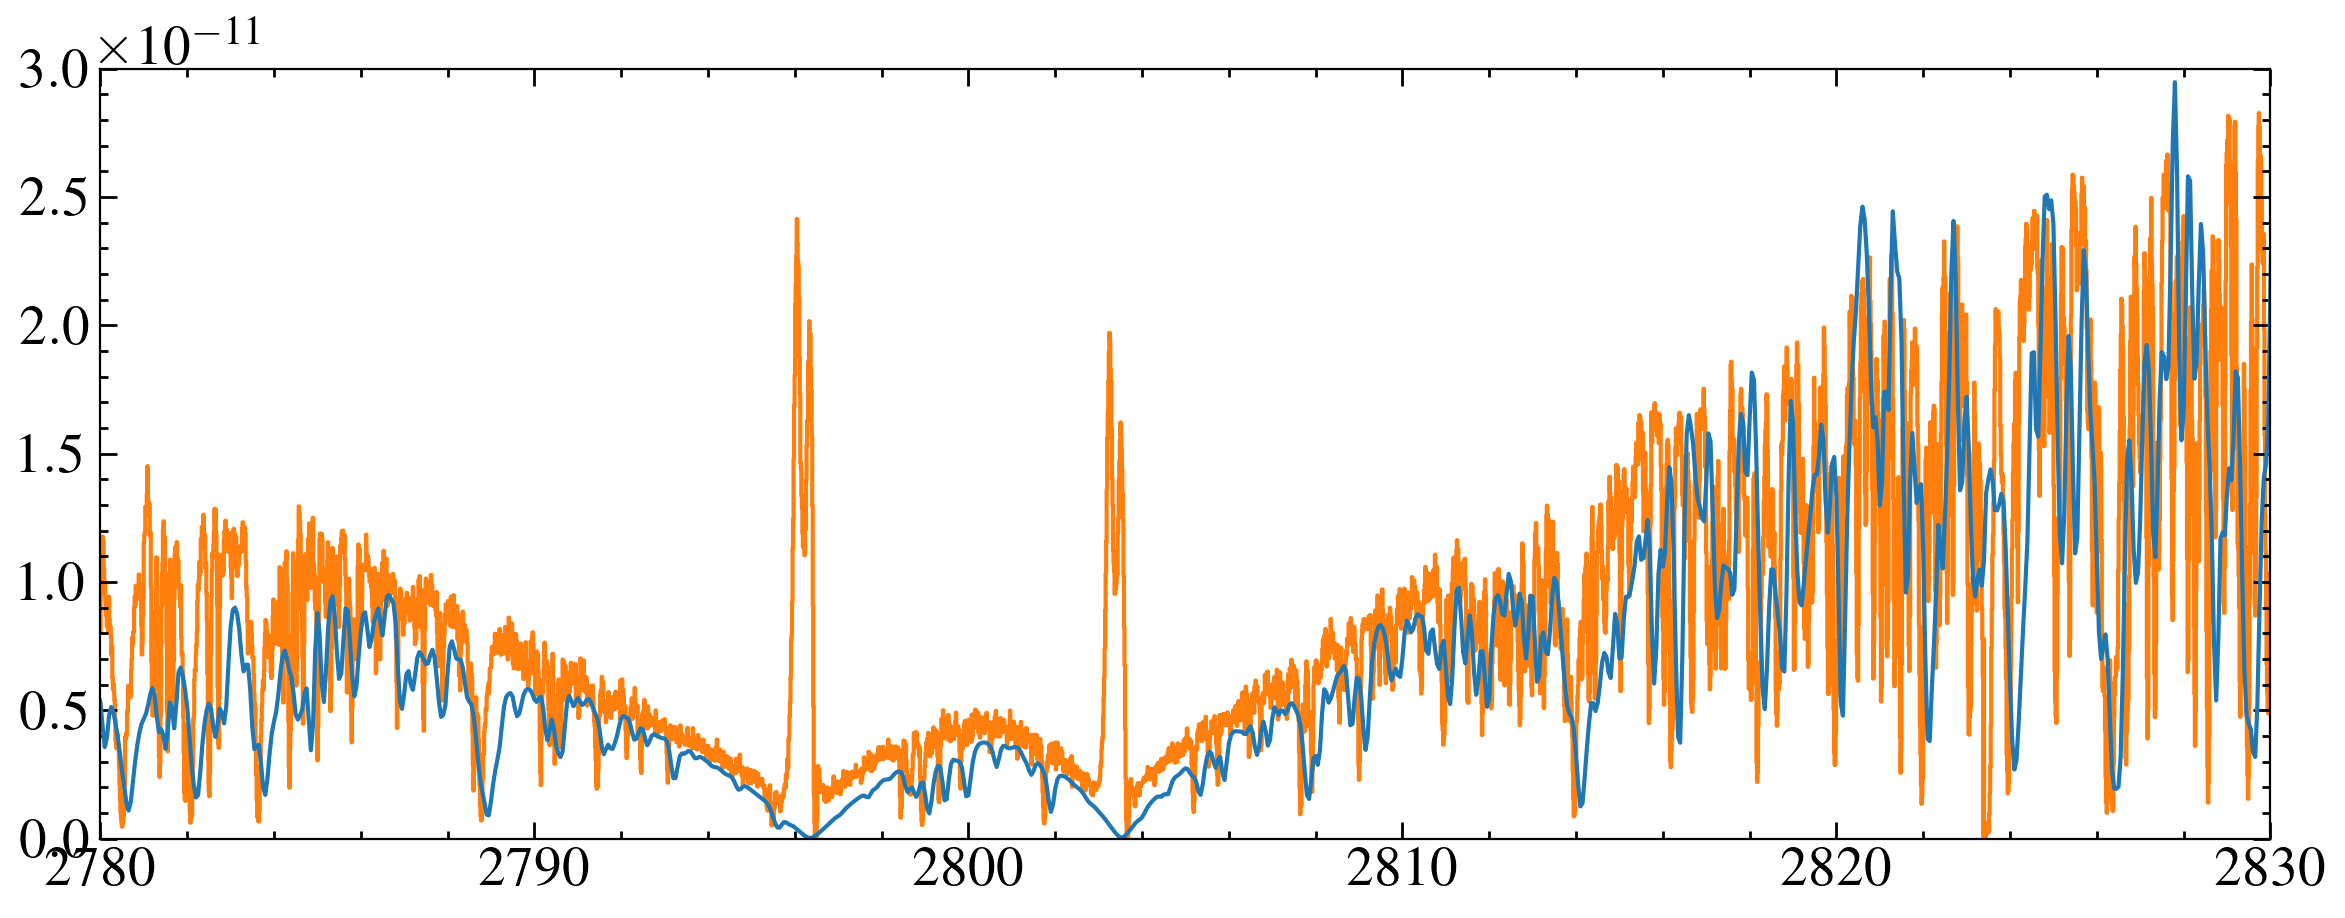

In [20]:
pmask = (pw > 2500) & (pw < 2900)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi, 228000)

plt.plot(pwi, pfi)

# plt.step(w_fuv, e_fuv, where='mid', zorder=-1)
plt.step(w_nuv, f_nuv, where='mid', label='E230H', zorder=-1)
# plt.plot(lyaw, lyamod)

# plt.xscale('log')
# plt.yscale('log')
# plt.ylim(1e-17)
# plt.xlim(w_nuv[0], w_nuv[-1])
plt.ylim(0, 3e-11)
plt.xlim(2780, 2830)

In [37]:
import importlib
import prepare_stis


<module 'prepare_stis' from '/home/david/work/meats/SEDs/prepare_stis.py'>

Make HLSP

In [38]:
path

'/media/david/2tb_ext_hd/hddata/meats/hst/tau_ceti/'

E140M yes
E140M yes
E140M yes
E140M yes
E140M yes


/home/david/work/meats/SEDs/prepare_stis.py:34: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/anaconda3/envs/stenv/lib/python3.10/site-packages/numpy/lib/function_base.py:550: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt,


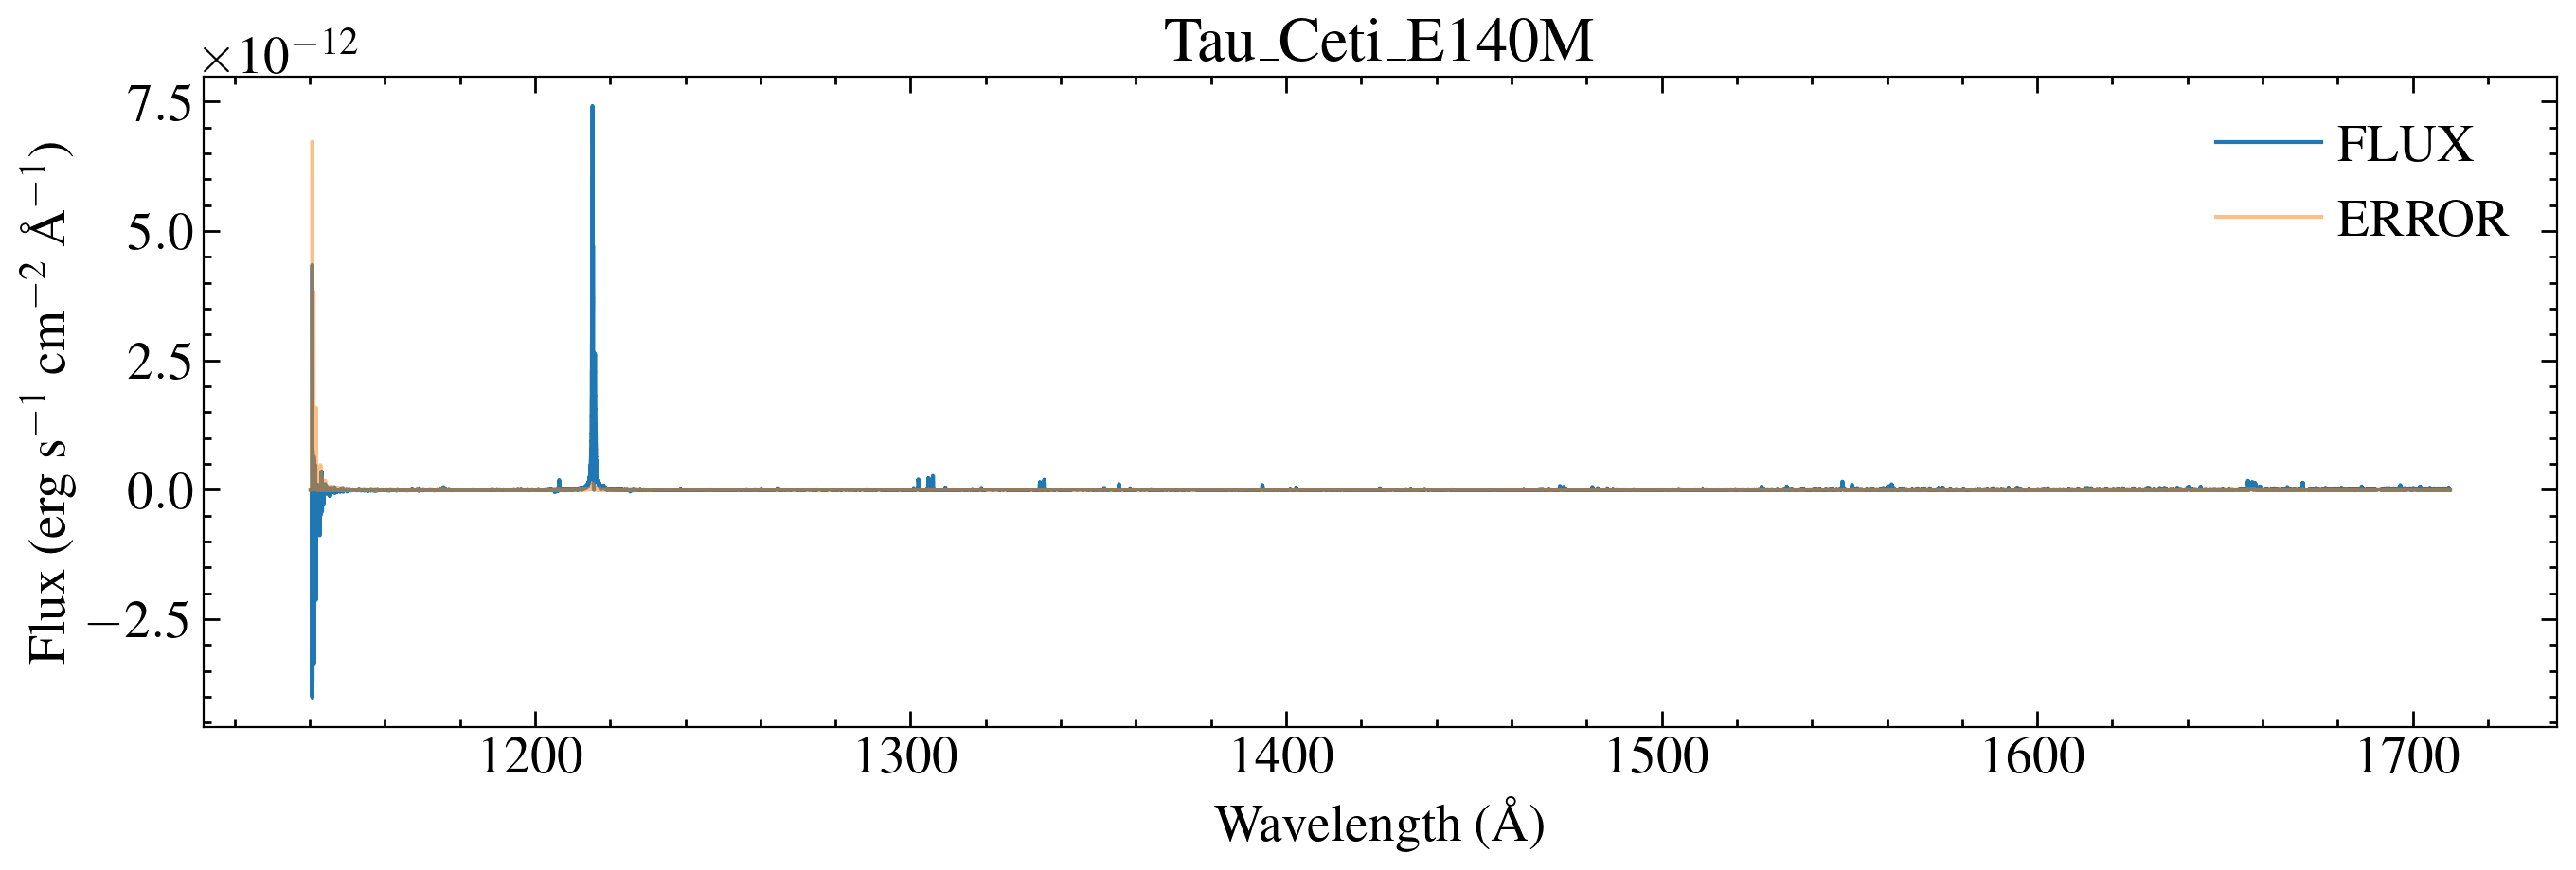

Spectrum saved as hlsp_muscles_hst_stis_tau_ceti_e140m_v1_component-spec.fits
E230H yes


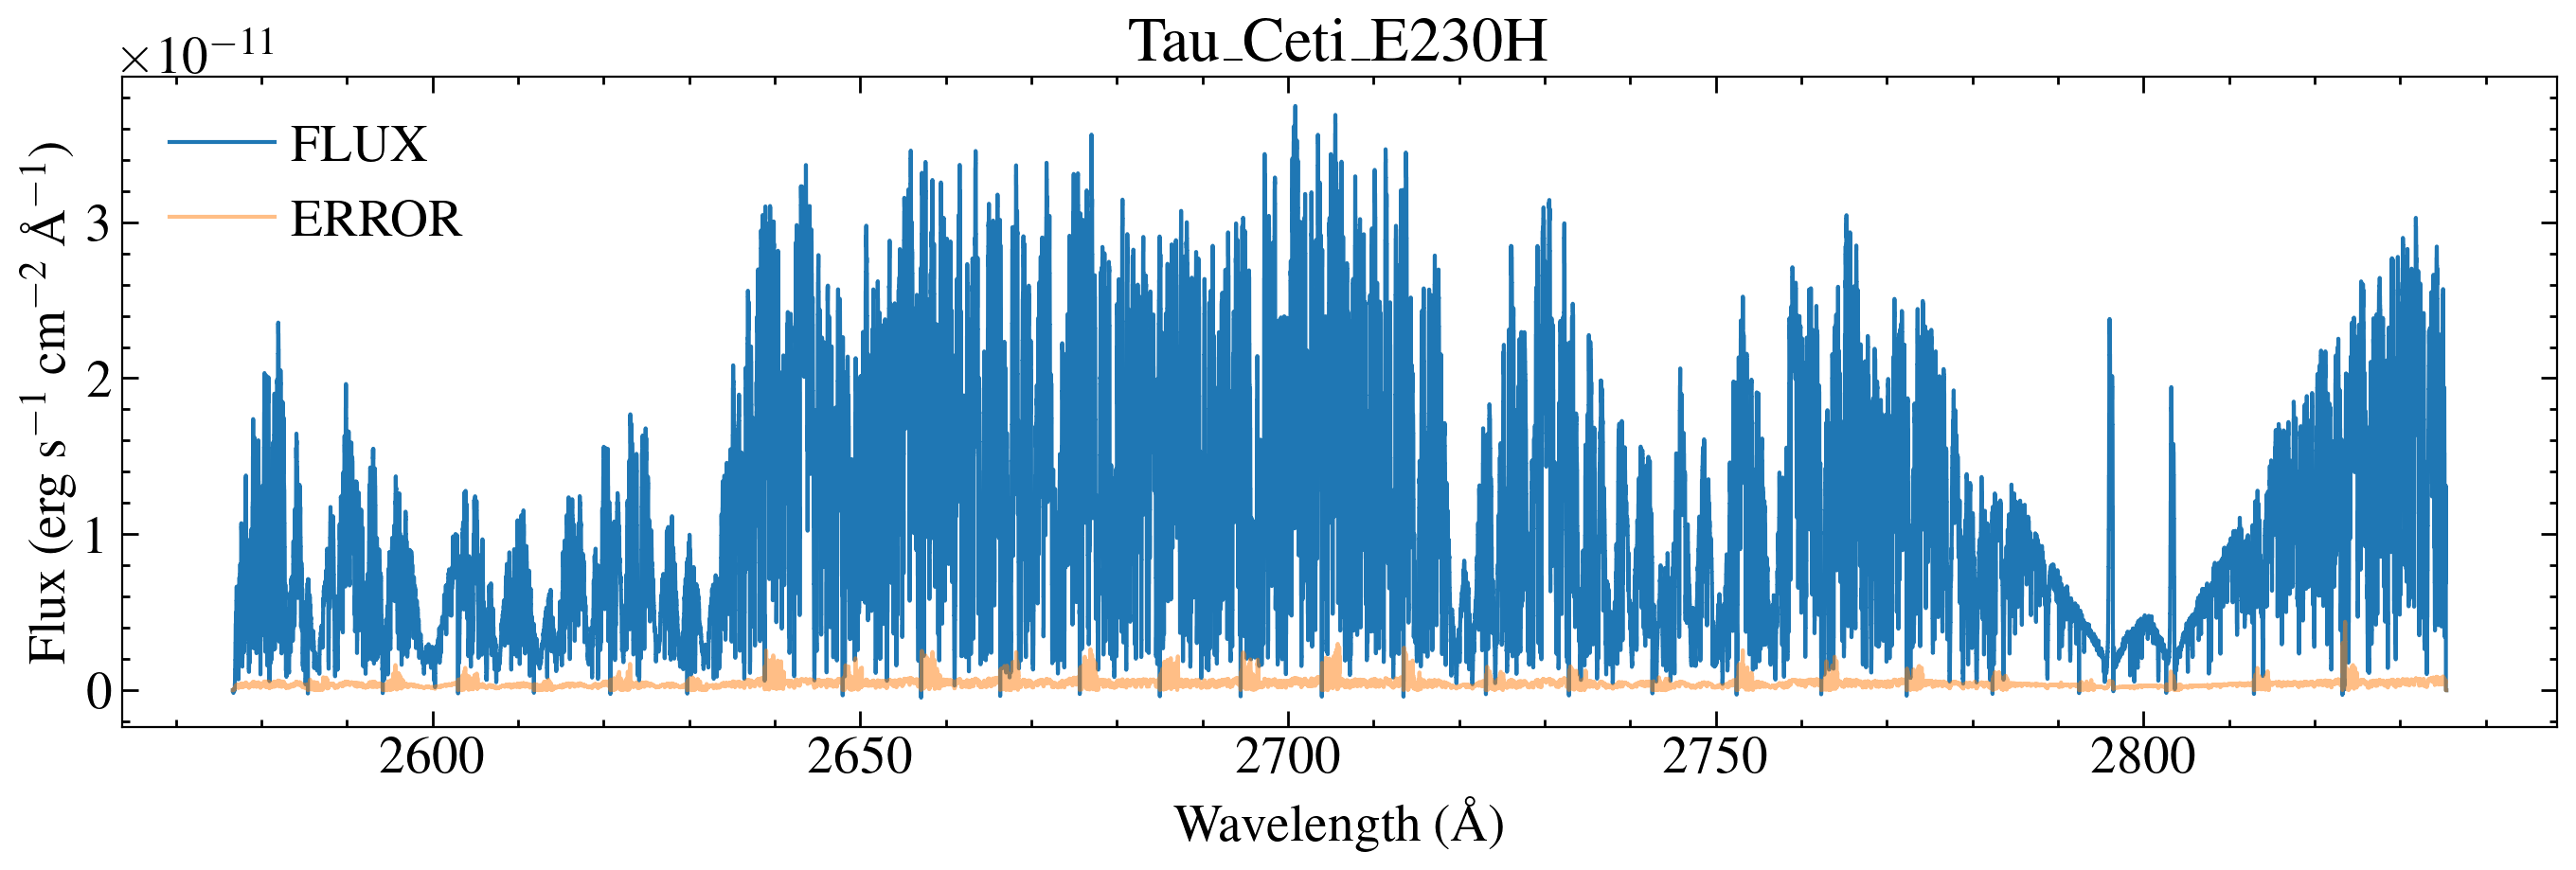

Spectrum saved as hlsp_muscles_hst_stis_tau_ceti_e230h_v1_component-spec.fits


In [62]:
importlib.reload(prepare_stis)
savepath = 'draft_hlsp/tau_ceti/'
hlsp = 'meats_hlsp_info.csv'
version = 1
star = 'Tau_Ceti'
prepare_stis.make_stis_spectrum(path, version, hlsp, savepath=savepath, plot=True, save_ecsv=False, save_fits=True, star=star)

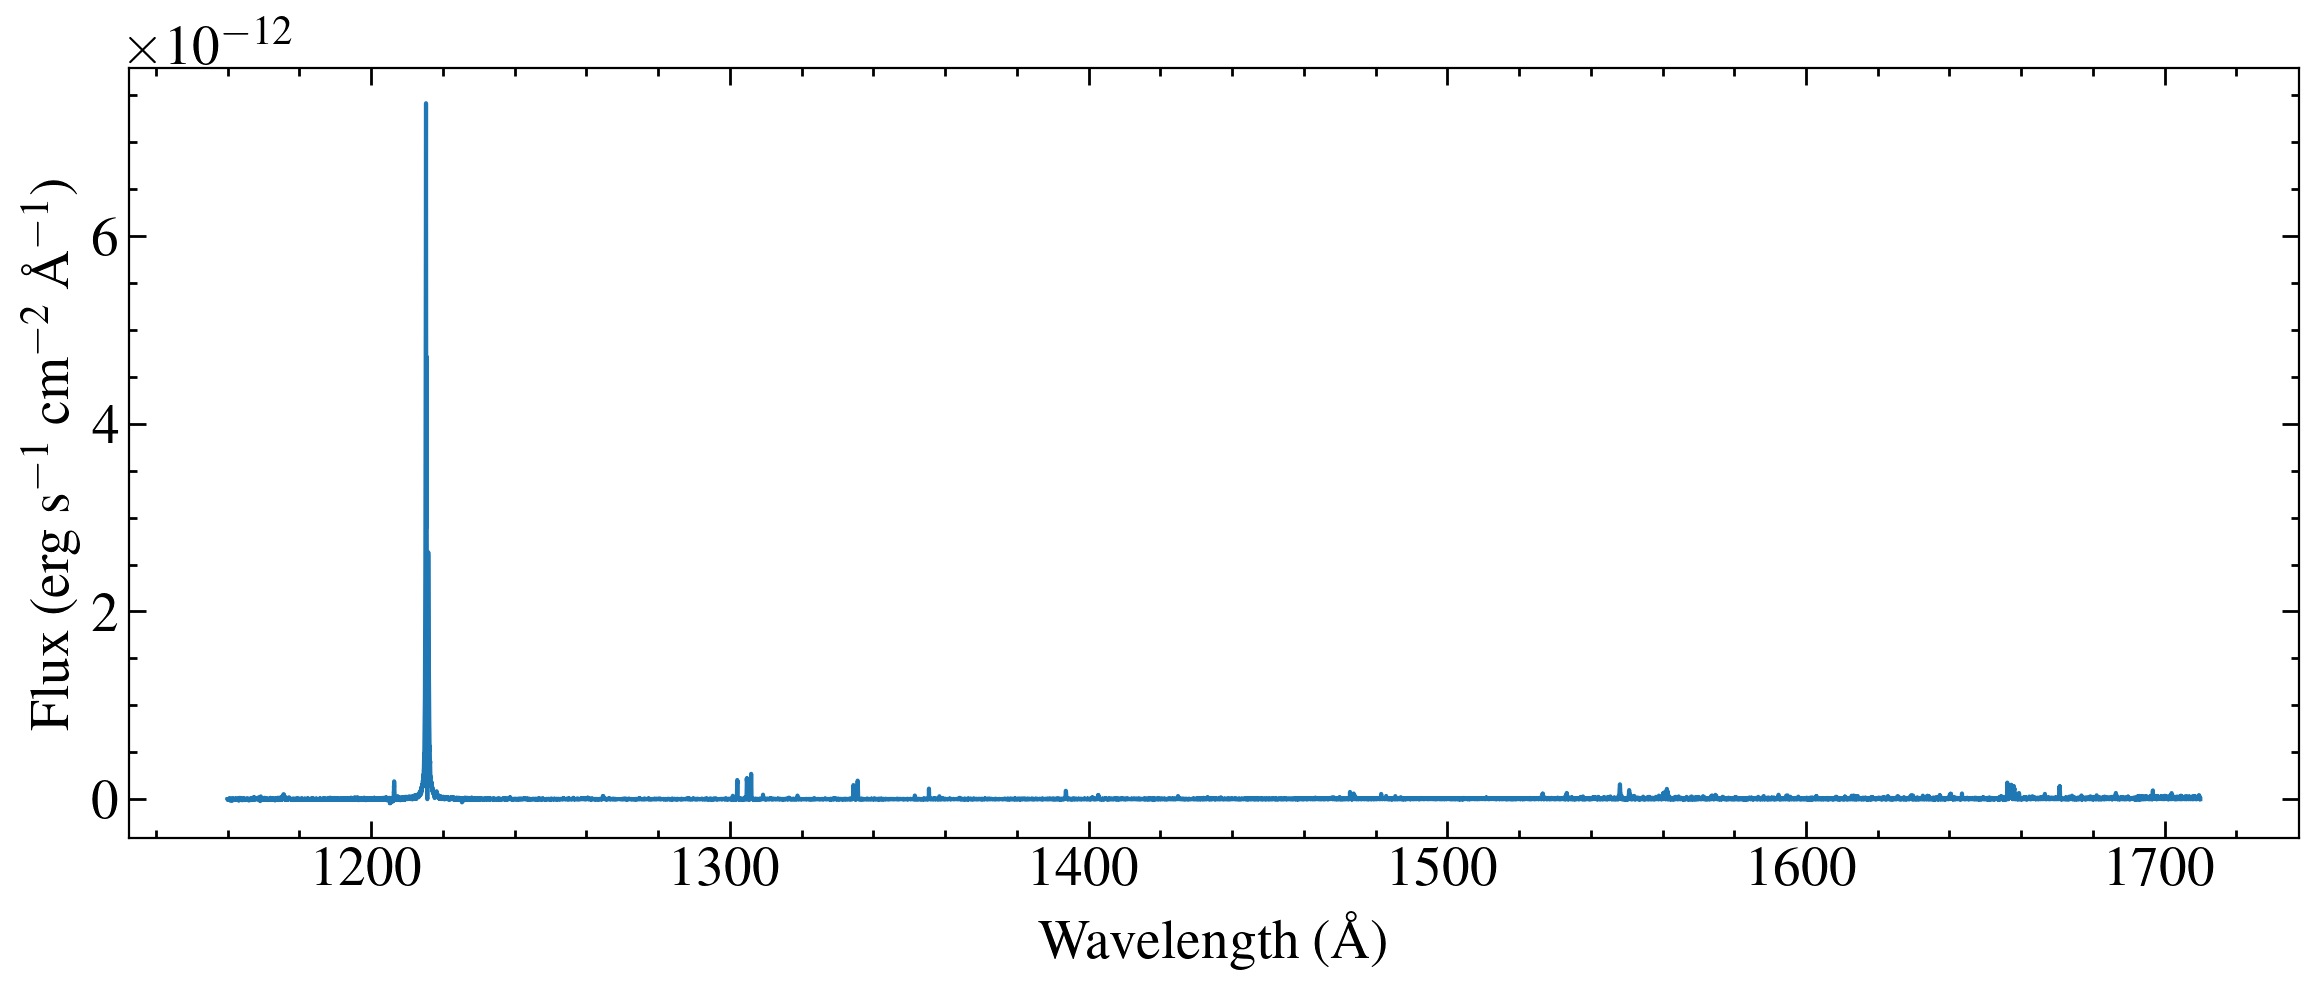

In [65]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt

data = fits.getdata('draft_hlsp/tau_ceti/hlsp_muscles_hst_stis_tau_ceti_e140m_v1_component-spec.fits')
w, f , e = data['WAVELENGTH'], data['FLUX'], data['ERROR']
mask = w > 1160
plt.plot(w[mask], f[mask])
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
plt.show()